<a href="https://colab.research.google.com/github/proffranciscofernando/DataScience-PUCRio-MVP2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pós-graduação em Data Science e Analytics - PUC Rio
## Sprint 2: Machine Learning & Analytics
## MVP enviado em 25/03/2024
## Francisco Fernando Roberto Pereira
#### francisco.fernando@ufpe.br
#### franciscofernando1989@gmail.com

# 1. Definição do problema

## 1.1. Dados e objetivos do trabalho



O dataset usado neste projeto será o **Wind Turbine SCADA** obtido do sistema SCADA (*Supervisory Control and Data Acquisition*) de um aerogerador proveniente de um parque eólico na Turkia durante o ano de 2018. Seu objetivo é fornecer dados de séries temporais para a construção de modelos preditivos para estimar a energia eólica gerada pelo aerogerador.

Os dados sobre os atributos foram aquisitados pelo sistema SCADA do aerogerador em intervalos de 10 minutos durante todo o ano de 2018. A descrição dos atributos é apresentada a seguir:
1. **Date/Time** - Data (em formato DD MM AAAA) e hora em intervalos de 10 minutos;
2. **LV Active Power (kW)** - Potência produzida pelo aerogerador num dado instante;
3. **Wind Speed (m/s)** - Velocidade do vento na altura do cubo do aerogerador (velocidade utilizada para a geração de eletricidade);
4. **Theoretical Power Curve (kWh)** - Valores teóricos de potência (fornecidos pelo fabricante) que o aerogerador produz com uma dada velocidade do vento;
5. **Wind Direction (°)** - Direção do vento na altura do cubo do aerogerador (aerogeradores se posicionam automaticamente para esta direção);

Para mais detalhes sobre este dataset, consulte: https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

Como o objetivo é fazer a previsão de uma variável contínua (produção de energia) com base em outras variáveis (potência teórica, direção e velocidade do vento), trata-se portanto de um problema em si é de aprendizado supervisionado, pois o modelo será treinado usando pares de entrada-saída. Nesse caso, com as séries temporais históricas de dados de produção de energia eólica, o modelo será treinado para aprender a relação entre os atributos selecionados (features) e a produção de energia (target).

Especificamente para esse MVP, os objetivos são:
*   Visualizar o dataset de várias maneiras diferentes para ganhar um entendimento geral dos dados;
*   Identificar e tratar valores *outliers*;
*   Separar adequadamente os dados para a fase de construção, treinamento e experimentação de modelos;

## 1.2. Premissas do problema e limitações dos dados

Ao abordar um problema de previsão de produção de energia eólica com base em séries temporais, podemos considerar as seguintes premissas:

*    Relação entre velocidade do vento e produção de energia: a hipótese fundamental pode ser que a produção de energia eólica está significativamente relacionada à velocidade do vento. Geralmente, espera-se que haja uma relação positiva entre a velocidade do vento e a produção de energia.

*    Efeito da direção do vento: a direção do vento também pode desempenhar um papel na produção de energia. Dependendo da orientação das turbinas eólicas, a direção do vento pode afetar a eficiência da produção.

*    Padrões temporais: é razoável supor que existam padrões sazonais ou temporais na produção de energia eólica. Por exemplo, certas épocas do ano podem ter ventos mais fortes, levando a uma maior produção.

O impacto de outras variáveis ambientais (como, por exemplo, temperatura, pressão atmosférica, umidade, etc) na produção de energia eólica não será levado em consideração no futuro modelo. Isso é uma limitação desse dataset, que não inclui essas variáveis.

Além disso, há a necessidade de estabelecermos os limites mínimo e máximo para a velocidade dos ventos. Dessa forma, temos:

1. Velocidade de corte (cut-in speed): para que um aerogerador produza eletricidade, é necessário que o vento tenha uma velocidade mínima, a partir da qual as turbinas eólicas começam a girar e a gerar eletricidade. Essa velocidade é conhecida como "cut-in speed". Para essa análise, a velocidade de corte será de 3 m/s.

2. Velocidade máxima (cut-out speed): por motivos de segurança, há um limite máximo de velocidade de vento para o equipamento. Para esse trabalho, a velocidade máxima será de 25 m/s.

Esses limites foram estabelecidos de acordo com as informações de operação da empresa Engie Wind Power (2023).

Fonte: [Wind Power | Engie](https://corporate.engie.be/en/energy/wind-power)



# 2. Análise inicial e visualização dos dados

## 2.1. Configuração inicial

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2.2. Carga de dados

Iremos usar o pacote Pandas (Python Data Analysis Library) para carregar de um arquivo .csv sem cabeçalho disponível online.

Com o dataset carregado, iremos explorá-lo um pouco.

In [3]:
# Carregar arquivo csv usando Pandas usando uma URL

# Informar a URL de importação do dataset
url = "https://raw.githubusercontent.com/proffranciscofernando/DataScience-PUCRio-MVP2/main/windturbine_scada_dataset.csv"

# Informar o cabeçalho das colunas
colunas = ['Date/Time', 'Active Power (kW)', 'Wind Speed (m/s)', 'Theoretical Power (kWh)', 'Wind Direction (°)']

# Ler o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')

## 2.3. Estatísticas descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [4]:
# Mostra as dimensões do dataset
instancias, atributos = dataset.shape
print(f'O dataset tem {instancias} instâncias e {atributos} atributos' )

O dataset tem 50530 instâncias e 5 atributos


In [5]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date/Time                50530 non-null  object 
 1   Active Power (kW)        50530 non-null  float64
 2   Wind Speed (m/s)         50530 non-null  float64
 3   Theoretical Power (kWh)  50530 non-null  float64
 4   Wind Direction (°)       50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None


In [6]:
# Mostra as 10 primeiras linhas do dataset
dataset.head(10)

,Date/Time,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698
9,01 01 2018 01:30,439.725708,5.523228,475.706783,258.723785


In [7]:
# Mostra as 10 últimas linhas do dataset
dataset.tail(10)

,Date/Time,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
50520,31 12 2018 22:20,2771.110107,10.154550,2884.512812,82.335197
50521,31 12 2018 22:30,3333.819092,12.067660,3532.081496,81.985901
50522,31 12 2018 22:40,3455.282959,12.195660,3549.150371,82.210617
50523,31 12 2018 22:50,3429.021973,12.492510,3578.567804,82.111870
50524,31 12 2018 23:00,3514.269043,12.559170,3583.288363,80.495262
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620


Nada de anormal foi detectado ao analisarmos as 10 primeiras e 10 últimas linhas do dataset. Para esse pequeno recorte dos dados, não há *missings*, *outliers* or inconsistências. Para uma análise mais aprofundada, teremos que usar outras formas de visualização.

In [8]:
# Verifica o tipo de dataset de cada atributo
dataset.dtypes

Date/Time                   object
Active Power (kW)          float64
Wind Speed (m/s)           float64
Theoretical Power (kWh)    float64
Wind Direction (°)         float64
dtype: object

É sempre importante verificar o tipo do atributos do dataset, pois pode ser necessário realizar conversões. Já fizemos anteriormente com o comando info, mas vamos ver uma outra forma de verificar a natureza de cada atributo e então exibir um resumo estatístico do dataset.

Nesse contexto, notamos que todos os atributos são do tipo "float64", com excessão do "Date/Time", que está no formato "object". Isso significa que esses dados estão sendo tratados como texto, ao invés de datas. Para realizar análises temporais eficazes, é essencial convertermos essa coluna para o formato de data e hora apropriado. Isso será feito posteriormente na seção de Pré-processamento de Dados.

In [9]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


A potência ativa (Active Power) é uma medida que indica a quantidade de energia sendo consumida ou gerada em um determinado momento. Dessa forma, a potência ativa geralmente não deve ser negativa, conforme mostrado pelo **valor mínimo de -2,471405 kW** para esse atributo. Isso sinaliza que pode haver outros valores abaixo de zero.

No entanto, em alguns contextos específicos, pode haver casos em que a potência ativa é expressa como um valor positivo, quando gerada, e como um valor negativo, quando consumida.

Um desses casos seria quando os aerogeradores não estão produzindo energia suficiente e precisam consumir da rede. Há ainda a situação onde pode haver mau funcionamento do sistema de controle e aquisição de dados (SCADA). Ambos os casos produzirão valores *outliers*, que precisam ser levados em consideração durante o tratamento dos dados.

Além disso, podemos fazer os seguintes comentários sobre a potência ativa (Active Power):
*   O **desvio padrão (std) de 1312.459242 kW** indica uma alta variabilidade do atributo. Isso indica que o dataset pode conter uma alta sazonalidade;
*   O **valor de 50.677890 kW que corresponde ao p25** indica há uma grande quantidade de baixas potências ativas. Isso será investigado posteriormente nesse MVP.

## 2.4. Visualizações unimodais

Agora vamos gerar **histogramas de distribuição de frequências** para o dataset.

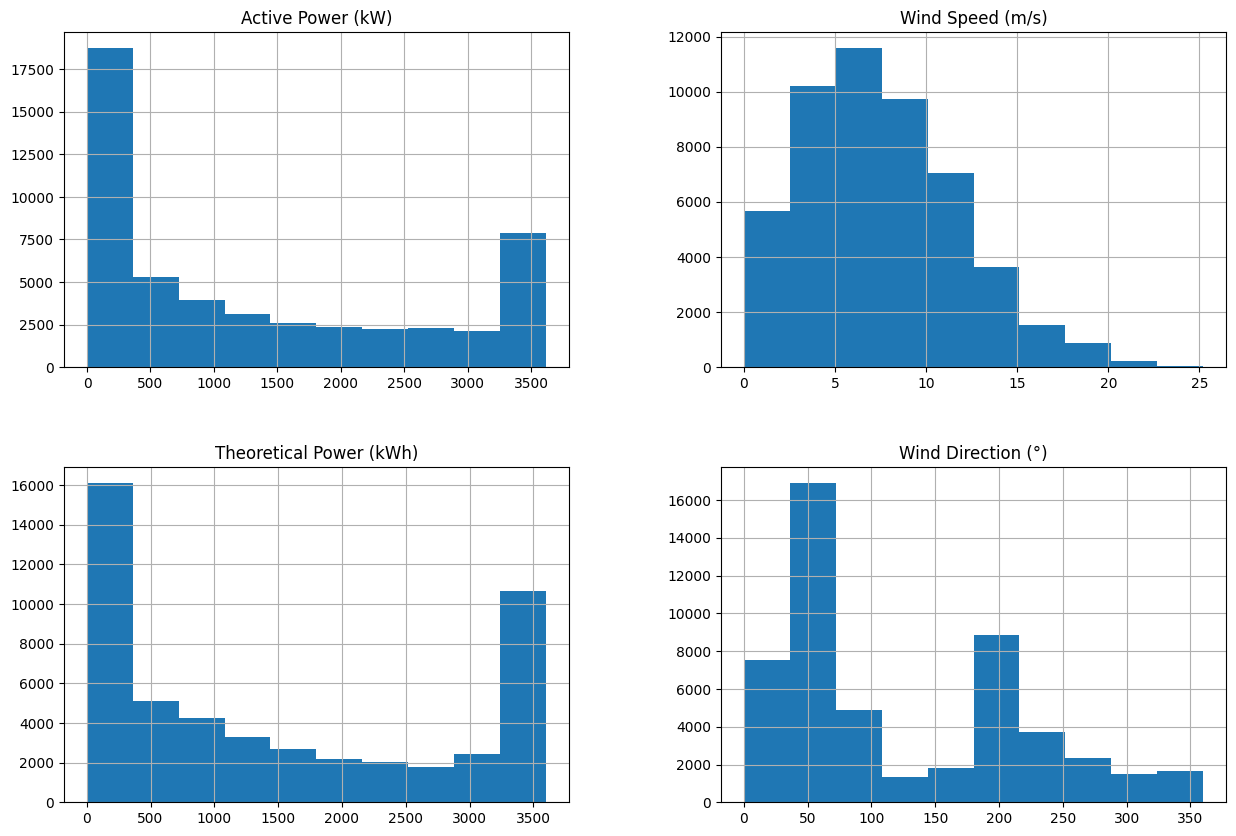

In [10]:
# Histogramas de frequências
dataset.hist(figsize = (15,10))
plt.show()

A partir dos histogramas, vemos que os atributos "Active Power", "Wind Direction" e "Theoretical Power" seguem uma distribuição bimodal aproximada, enquanto que a "Wind Speed" segue uma distribuição aproximadamente normal.

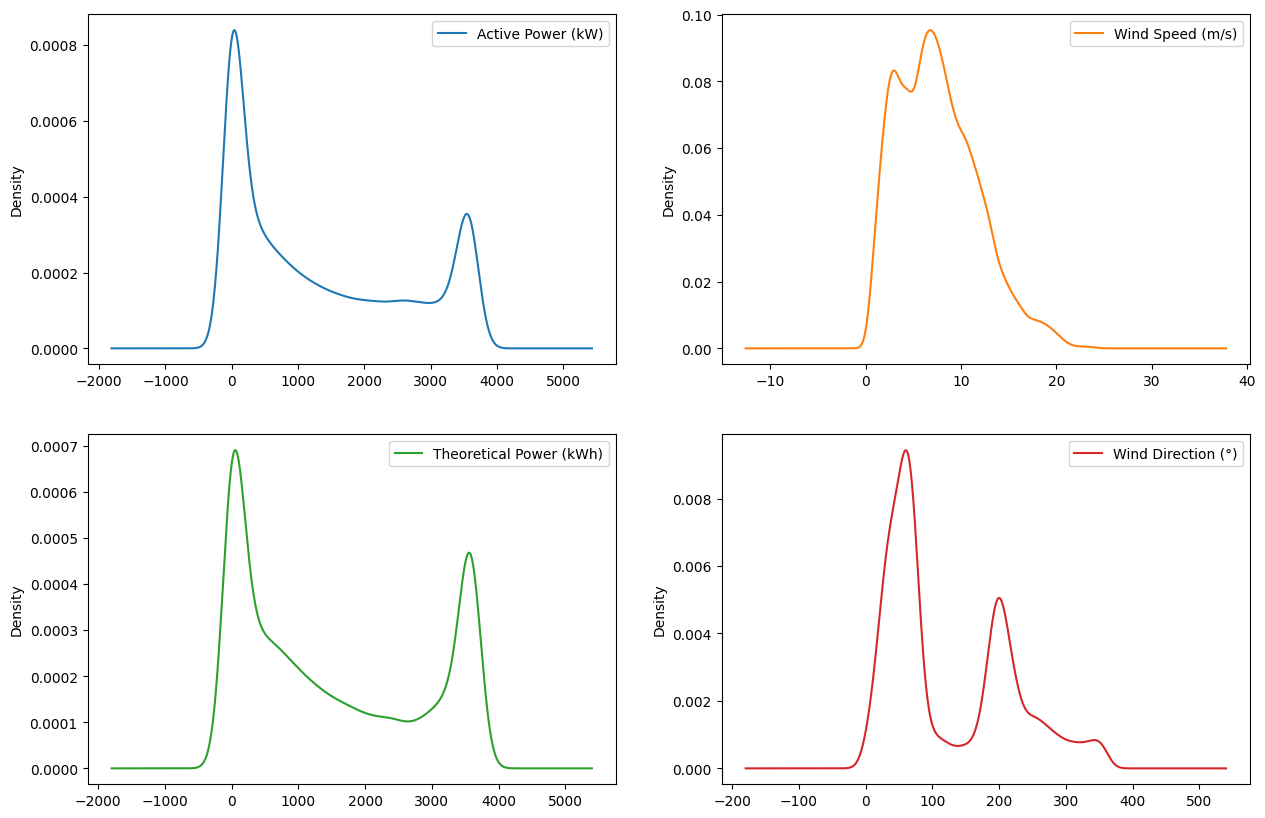

In [11]:
# Density Plot
dataset.plot(kind = 'density', subplots = True, layout = (2,2), sharex = False, figsize = (15,10))
plt.show()

O **gráfico de densidade**, ou **density plot**, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, criamos um density plot para cada atributo do dataset. Vemos que muitos dos atributos têm uma distribuição distorcida.

Tanto o histograma quanto o density plot do atributo "Active Power" mostram que há uma grande concentração de dados próximos de zero. Esses valores serão tratados como *outliers*, pois podem introduzir no modelo um comportamento anômalo, condições de operação especial que podem não ser representativas do comportamento normal do sistema, conforme explicado na seção de Definição do Problema.

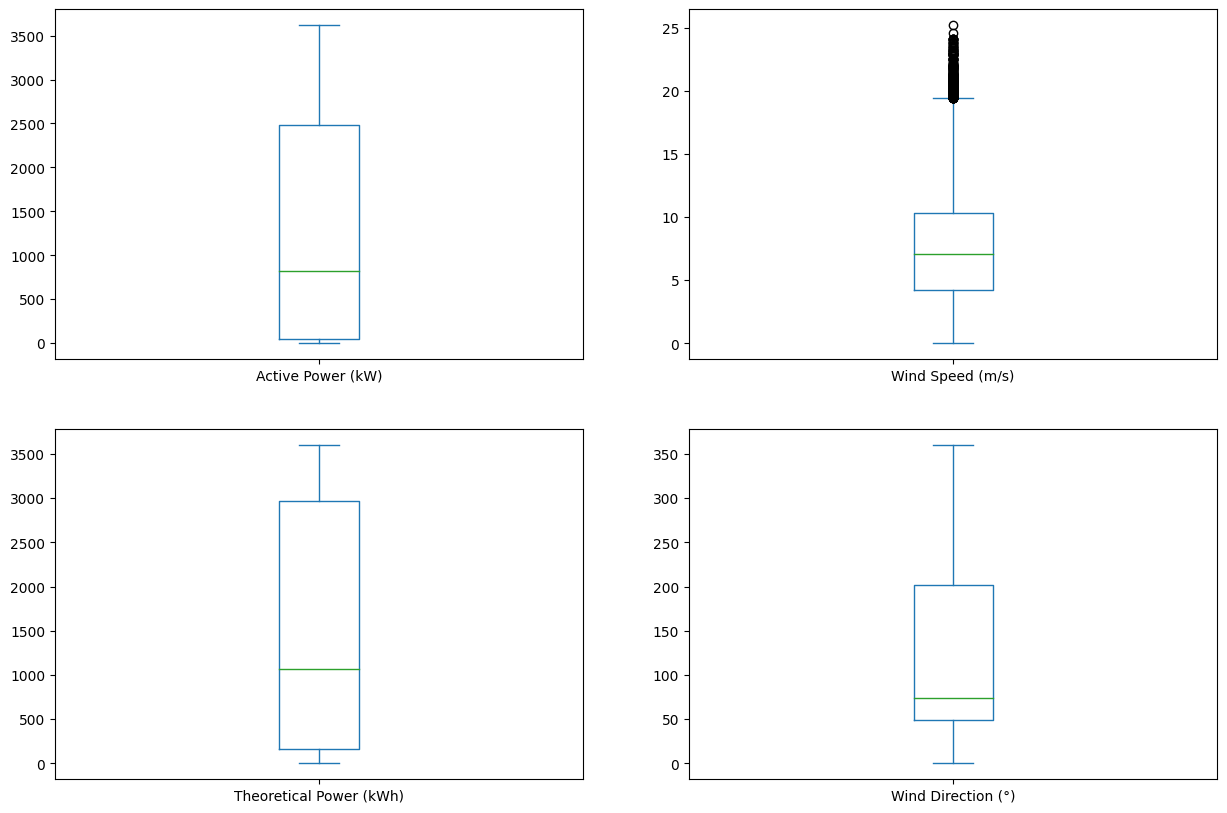

In [12]:
# Boxplot
dataset.plot(kind = 'box', subplots = True, layout = (2,2), sharex = False, sharey = False, figsize = (15,10))
plt.show()

No boxblot, a linha no centro (verde) representa o valor da mediana (segundo quartil ou p50). A linha abaixo é o 1o quartil (p25) e a linha acima o terceiro quartil (p75). O boxplot ajuda a ter uma ideia da dispersão dos dataset e os possíveis outliers.

Analisando os gráficos bloxplot, percebemos que a dispersão dos atributos do dataset é bem diferente. Para o caso da "Wind Speed", há pontos fora das linhas horizontais (>20 m/s) que, em teoria, seriam considerados *outliers*. Porém, há épocas do ano onde velocidades de vento elevadas são esperadas e não são anômalas. O futuro modelo deve ser capaz de prever esse contexto e, por essa razão, uma parte desses dados deve ser mantida. Isso será feito na seção de Tratamento de Outliers.

## 2.5. Visualizações multimodais

A **matriz de correlação** a seguir exibe graficamente a correlação entre os atributos numéricos do dataset.

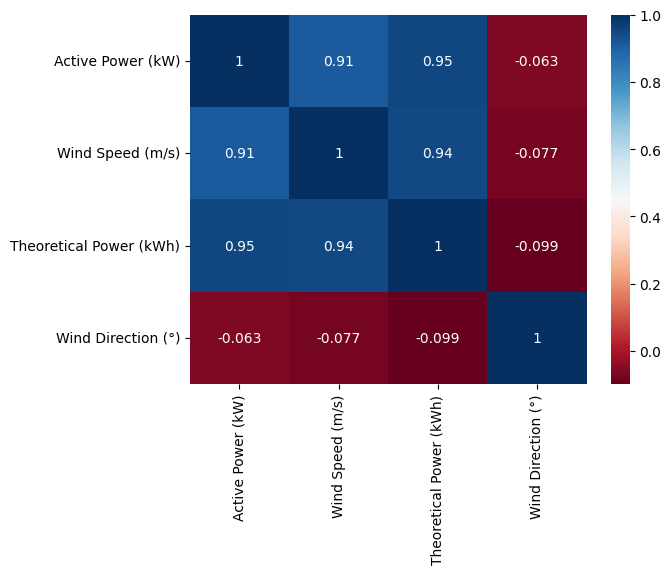

In [13]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(dataset.corr(), annot=True, cmap='RdBu');

Ao visualizar as correlações entre os atributos através da matriz de correlação, percebemos que há uma estrutura na ordem dos atributos.

Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis,
* Próximo de +1: há uma correlação positiva entre as variáveis.
* 0: não há correlação entre as variáveis.

Nesse contexto, todos os atributos são altamente correlacionados entre si, de acordo com os coeficientes de correlação de Pearson (todos acima de 0.9). A única excessão é a direção do vento (Wind Direction), que possui uma baixíssima correlação negativa com os demais atributos. Como os valores dos coeficientes de correlação são muito baixos, essa correlação pode ser considerada inexistente.

Esta informação sobre a correlação entre os atributos é relevante porque alguns algoritmos como regressão linear e regressão logística podem apresentar problemas de performance se houver atributos altamente correlacionados. Vale a pena consultar a documentação do algoritmo para verificar se algum tipo de tratamento de dataset é necessário.

Por sua vez, o gráfico de dispersão (**scatter plot**) mostra o relacionamento entre duas variáveis. Vamos exibir um para cada par de atributos dos dataset, usando o Seaborn.

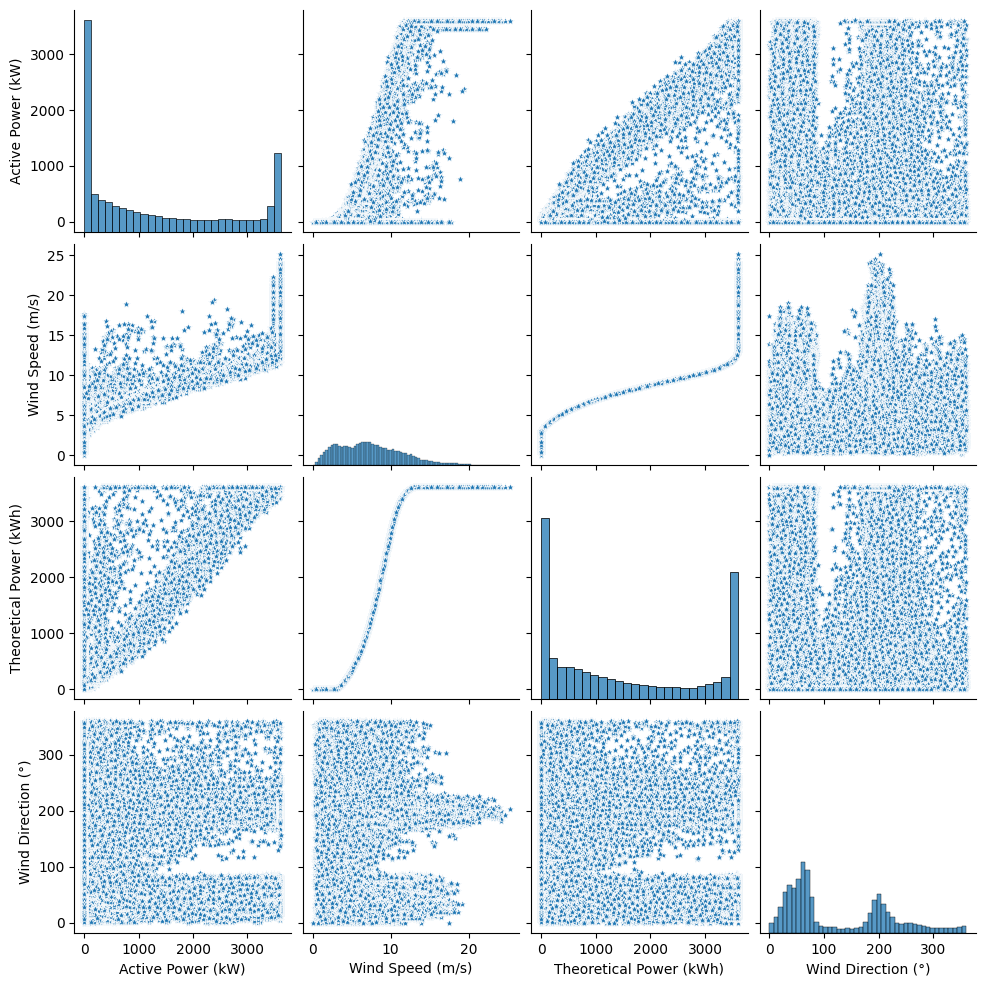

In [14]:
# Scatter Plot com Seaborn
sns.pairplot(dataset, markers='*')

Nesse scatter plot, os gráficos diagonais fornecem histogramas da distribuição de probabilidade univariadas para cada variável. Esses histogramas mostram como os valores de cada variável estão distribuídos.

Fora da diagonal principal, cada célula contém um gráfico de dispersão que representa a relação entre duas variáveis. Isso ajuda a visualizar a correlação ou dependência entre pares de variáveis. Nesse contexto, destacamos que os atributos "Active Power" e "Theoretical Power" possuem uma distribuição triangular acima e abaixo da diagonal principal, o que sugere uma relação linear entre as variáveis.

Nessa altura, também podemos visualizar as curvas de potência do aerogerador (Active Power x Wind Speed e Theoretical Power x Wind Speed). Para uma comparação mais efetiva, vamos plotar essa curva separadamente a seguir.

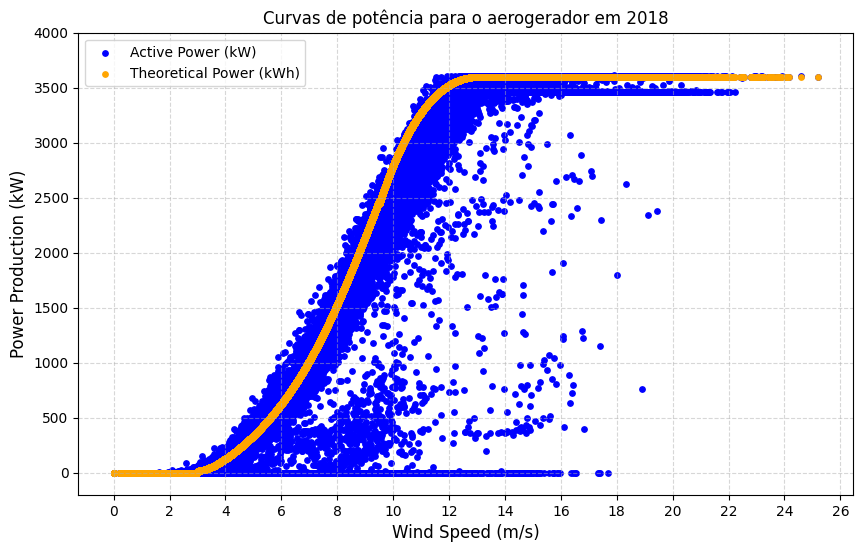

In [15]:
# Plotar curvas de potência para o aerogerador

# Preparar a figura
plt.figure(figsize=(10, 6))

# Potência ativa
plt.scatter(dataset['Wind Speed (m/s)'], dataset['Active Power (kW)'], label='Active Power (kW)', color='blue', marker="o", s=15)

# Potência teórica
plt.scatter(dataset['Wind Speed (m/s)'], dataset['Theoretical Power (kWh)'], label='Theoretical Power (kWh)', color='orange', marker="o", s=15)

# Exibir legenda
plt.legend()

# Nomenclatura dos eixos x e y
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Production (kW)', fontsize=12)
plt.title('Curvas de potência para o aerogerador em 2018')

# Definir explicitamente os limites do eixo x
xmin = 0  # Especificar o limite inferior
xmax = 26  # Especificar o superior
x_step = 2  # Especificar o passo
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0  # Especificar o limite inferior
ymax = 4000  # Especificar o superior
y_step = 500  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin-200, ymax)

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.show()

Analisando as curvas de potência, podemos perceber que a potência ativa (Active Power) possui uma grande quantidade de valores *outliers* em relação à potência teórica (Theoretical Power). Isso será tratado na seção de Tratamento dos Outliers.

# 3. Preparação dos dados

Nesta etapa, poderíamos realizar diversas operações de preparação de dados, como por exemplo, tratamento de valores *missings*, limpeza de dados, transformações, seleção de características (feature selection).

## 3.1. Manipulação inicial do dataset

Essa manipulação inicial do dataset será útil para viabilizar operações relacionadas a datas e horas, como extrair componentes de data (ano, mês, dia, etc.), realizar cálculos com datas, entre outras operações específicas para dados temporais.

In [16]:
# Fazer cópia de segurança do dataset original
datasetTemporal = dataset.copy()

In [17]:
# Converter 'Date/Time' para datetime
datasetTemporal['Date/Time'] = pd.to_datetime(datasetTemporal['Date/Time'])

# Criar a coluna 'Month' diretamente no formato de período
datasetTemporal['Month'] = datasetTemporal['Date/Time'].dt.to_period('M')

# Converter 'Month' novamente para datetime
datasetTemporal['Month'] = datasetTemporal['Month'].dt.to_timestamp()

# Inserir a coluna 'Month' após 'Date/Time'
datasetTemporal.insert(1, 'Month', datasetTemporal.pop('Month'))

In [18]:
print(datasetTemporal)

                Date/Time      Month  Active Power (kW)  Wind Speed (m/s)  \
0     2018-01-01 00:00:00 2018-01-01         380.047791          5.311336   
1     2018-01-01 00:10:00 2018-01-01         453.769196          5.672167   
2     2018-01-01 00:20:00 2018-01-01         306.376587          5.216037   
3     2018-01-01 00:30:00 2018-01-01         419.645905          5.659674   
4     2018-01-01 00:40:00 2018-01-01         380.650696          5.577941   
...                   ...        ...                ...               ...   
50525 2018-12-31 23:10:00 2018-12-01        2963.980957         11.404030   
50526 2018-12-31 23:20:00 2018-12-01        1684.353027          7.332648   
50527 2018-12-31 23:30:00 2018-12-01        2201.106934          8.435358   
50528 2018-12-31 23:40:00 2018-12-01        2515.694092          9.421366   
50529 2018-12-31 23:50:00 2018-12-01        2820.466064          9.979332   

       Theoretical Power (kWh)  Wind Direction (°)  
0                   41

Agora criaremos um resumo estatístico mensal com o objetivo de analisar as médias e medianas. Para ilustrar essa comparação, na sequência também faremos os gráficos de linha.

In [19]:
# Agrupar os dados por mês e realize a agregação necessária (por exemplo, média, soma, etc.)
resumoMensal = datasetTemporal.groupby('Month').agg({'Active Power (kW)': ['mean', 'median'],
                                              'Wind Speed (m/s)': ['mean', 'median'],
                                              'Theoretical Power (kWh)': ['mean', 'median'],
                                              'Wind Direction (°)': ['mean', 'median']}).reset_index()

# Exiba o DataFrame resultante
print(resumoMensal)

        Month Active Power (kW)              Wind Speed (m/s)            \
                           mean       median             mean    median   
0  2018-01-01       1469.538834   930.772888         9.407847  9.049827   
1  2018-02-01       1398.812191  1022.821991         8.179499  7.863296   
2  2018-03-01       1778.547254  1582.933960         9.204149  8.434291   
3  2018-04-01       1062.471714   473.491699         6.740089  5.879722   
4  2018-05-01       1099.212305   675.612213         6.693869  6.633387   
5  2018-06-01       1168.209523   768.023315         6.844458  6.763925   
6  2018-07-01        694.432261   226.971794         5.474675  4.804646   
7  2018-08-01       1510.816574  1180.406494         8.050320  7.703878   
8  2018-09-01       1491.921321  1016.616028         7.704346  7.300117   
9  2018-10-01       1178.213240   832.783264         6.859317  6.778285   
10 2018-11-01       1745.561611  1558.900024         8.871619  8.265819   
11 2018-12-01       1189.

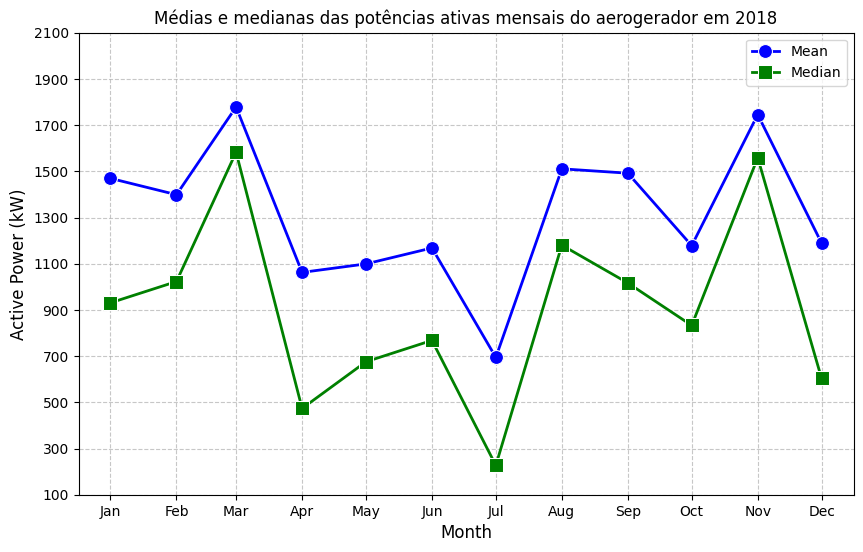

In [20]:
# Plotar o gráfico de linha usando seaborn da média mensal e mediana da potência ativa do aerogerador no ano de 2018
plt.figure(figsize=(10, 6))

# Linha da média
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'mean'), label='Mean', color='blue', marker="o", linewidth=2, markersize=10)

# Linha da mediana
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'median'), label='Median', color='green', marker="s", linewidth=2, markersize=10)

# Nomenclatura dos eixos x e y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Médias e medianas das potências ativas mensais do aerogerador em 2018')

# Definir explicitamente os limites do eixo x
xmin = resumoMensal['Month'].min() - pd.to_timedelta('15 days')  # Subtrai 15 dias do mínimo
xmax = resumoMensal['Month'].max() + pd.to_timedelta('15 days')  # Adiciona 15 dias ao máximo
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10) # Definir tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 100  # Especificar o limite inferior
ymax = 2100  # Especificar o superior
y_step = 200  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin, ymax)

# Ajustar o formato do eixo x para exibir os nomes para cada mês do ano
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

Através do gráfico, vemos que a potência ativa média é maior do que a sua mediana em todos os meses no ano de 2018.

A média é mais sensível a valores extremos do que a mediana. Portanto, apenas alguns valores de dados excepcionalmente altos terão um impacto mais significativo na média do que na mediana. É provável que haja picos de produção de energia em semanas ou dias específicos todos os meses e que isso esteja aumentando o valor médio da potência produzida.

## 3.2. Verificação e tratamento de missings

Faremos agora a verificação de possíveis missings.



In [21]:
# Verificar nulls no dataset
datasetTemporal.isnull().sum()

Date/Time                  0
Month                      0
Active Power (kW)          0
Wind Speed (m/s)           0
Theoretical Power (kWh)    0
Wind Direction (°)         0
dtype: int64

<Axes: >

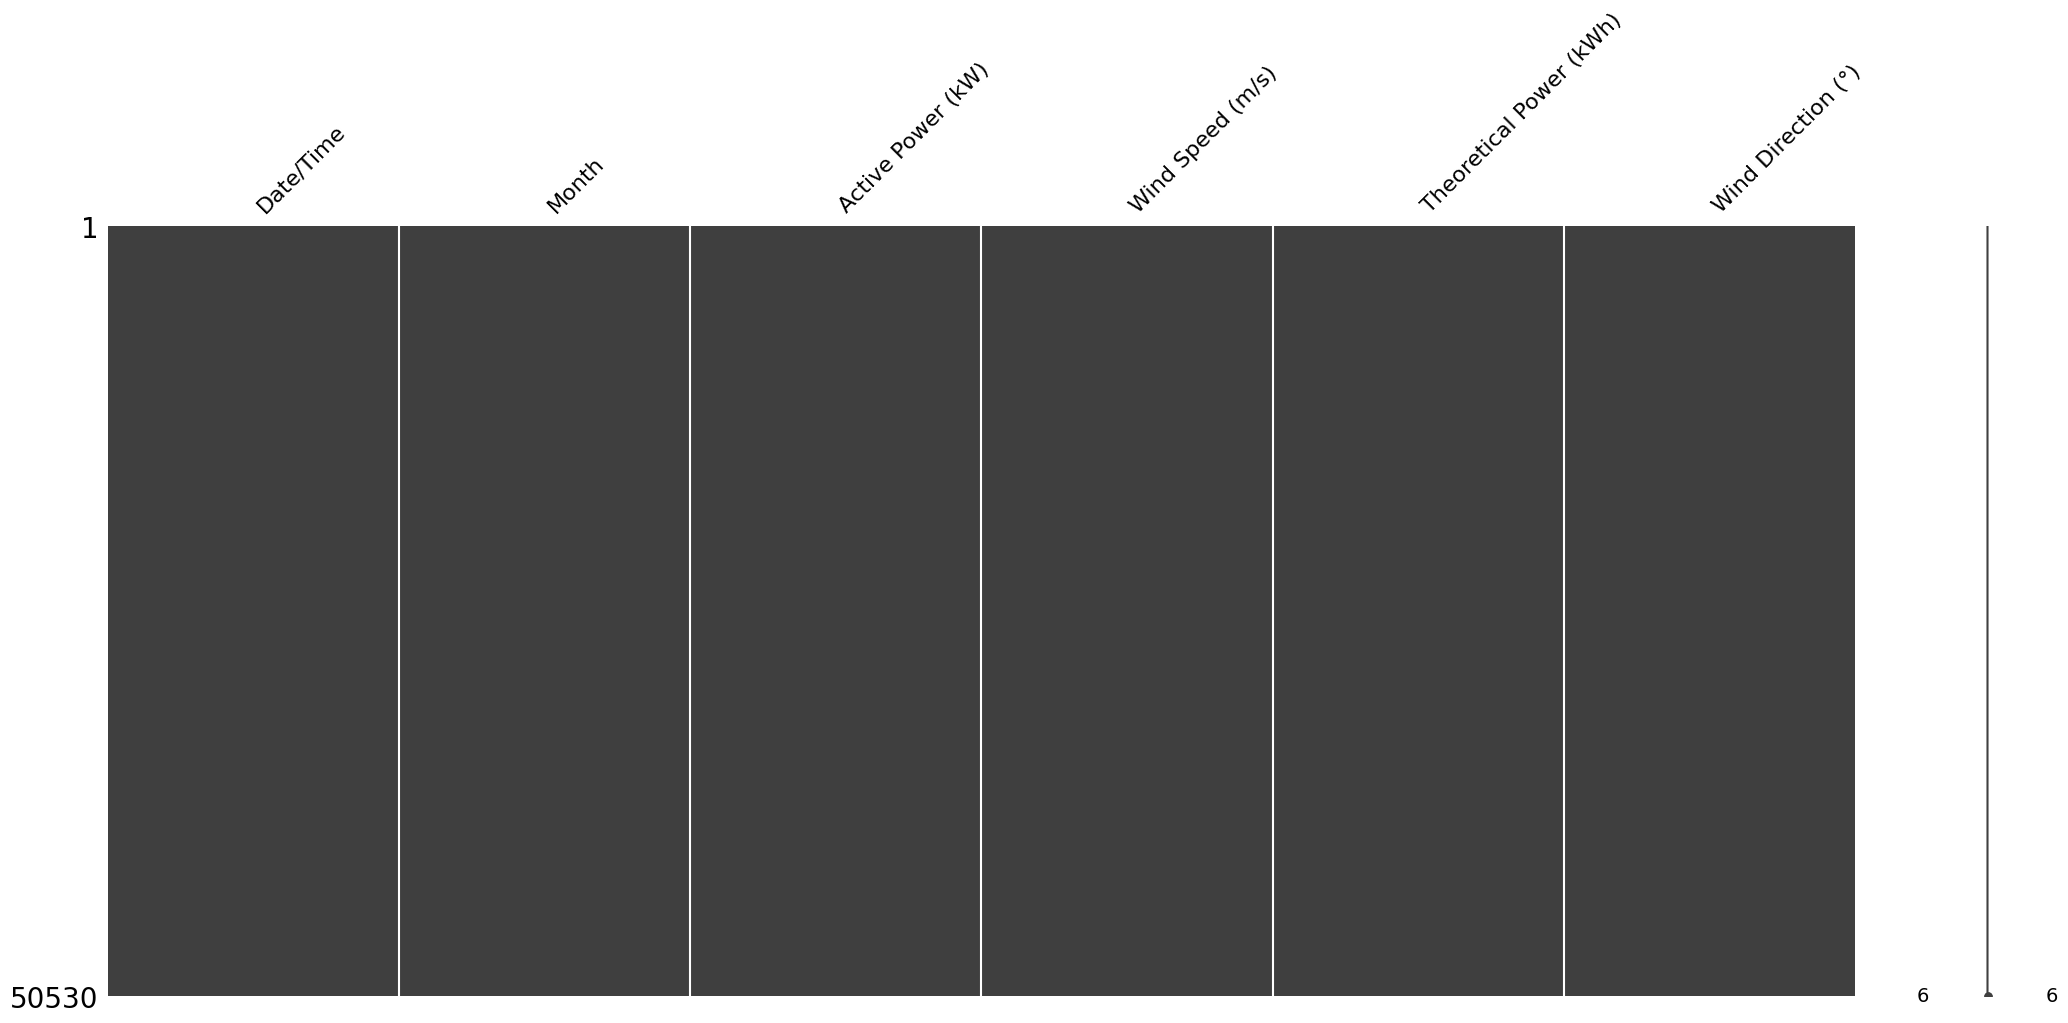

In [22]:
# Exibir visualização matricial da nulidade do dataset
ms.matrix(datasetTemporal)

Visualizamos, a partir da matrix e dos *nulls*, que o dataset não tem *missings* aparentes.




## 3.3. Tratamento dos outliers

As três fontes de valores *outliers* consideradas nesse projeto serão as seguintes:

**1. Valores de potência ativa negativos ou próximos de zero:**

 * Descrição: os valores da potência tendem a zero quando a velocidade do vento está acima da velocidade de corte (cut-in) e abaixo da velocidade de desligamento (cut-out).

 * Possíveis causas: manutenção da turbina eólica e limitação de vento.

**2. Valores distantes da curva de potência teórica:**

* Descrição: os valores de potência ativa estão significativamente afastadas dos valores esperados, conforme representados pela curva de potência teórica, mas não são iguais a zero.

* Possíveis causas: limitação de vento, sujeira nas pás, insetos ou gelo, mau funcionamento do controle de inclinação, entre outros fatores.

**3. Valores que excedem a limitação física do equipamento:**

* Descrição: A potência do vento atinge valores que ultrapassam a limitação física da turbina eólica.

* Possíveis causas: condições operacionais extremas.

Esses três tipos de valores *outliers* são analisados para compreender as características que podem introduzir erros na modelagem da curva de potência. Por essa razão, é fundamental identificar e remover esses outliers dos dados brutos antes de utilizá-los para treinar futuros modelos.

In [23]:
# Criar uma cópia de segurança do dataset antes das manipulações
datasetCopiaSegura = datasetTemporal.copy()

Faremos agora a divisão do dataset em subconjuntos com base nos valores de 'ActivePower (kW)'. Em seguida, removeremos os *outliers* em cada subconjunto e concatenaremos os subconjuntos tratados para criar um novo dataset sem *outliers*. Esse processo será realizado de forma dinâmica, ajustando os critérios de remoção de *outliers* com base nos intervalos específicos dos valores de 'ActivePower (kW)'.







In [24]:
# Função para remover outliers
def remover_outliers(df, coluna, percentil_min, percentil_max):
    """
    Essa função remove os outliers de um coluna específica do dataset,
    utilizando percentis mínimo e máximo.
    """
    # Calcula os quartis para os percentis mínimos e máximos
    q_baixo = df[coluna].quantile(percentil_min)
    q_alto = df[coluna].quantile(percentil_max)

    # Filtra o DataFrame mantendo apenas os valores dentro do intervalo definido pelos quartis
    return df[(df[coluna] < q_alto) & (df[coluna] > q_baixo)]

In [25]:
# Função para criar subconjuntos de dados
def criar_subconjuntos_de_dados(data, passo=50, limite_superior=3400):
    """
    Essa função divide o dataset em subconjuntos com base nos valores da
    coluna 'ActivePower (kW)'. Cada subconjunto abrange um intervalo
    específico (definidos pelo passo) e armazena o subconjunto num
    dicionário. Cada subconjunto é representado por um intervalo inferior
    e o último subconjunto inclui valores maiores ou iguais a 3300.
    """
    subconjuntos = {}
    for limite_inferior in range(20, limite_superior, passo):
        limite_superior_atual = limite_inferior + passo
        # Condição para criar o subconjunto baseado nos limites
        condicao = (data['Active Power (kW)'] >= limite_inferior) & (data['Active Power (kW)'] < limite_superior_atual)
        subconjuntos[limite_inferior] = data[condicao]

    # Adiciona o último subconjunto para valores >= 3300
    subconjuntos[limite_superior] = data[data['Active Power (kW)'] >= 3300]

    return subconjuntos

In [26]:
# Criar subconjuntos de dados
subconjuntos_de_dados = criar_subconjuntos_de_dados(datasetCopiaSegura)

# Remoção de outliers para cada subconjunto de dados
for limite_inferior, df in subconjuntos_de_dados.items():
    if limite_inferior <= 3:
        F = 0.95
    elif 3 < limite_inferior <= 10:
        F = 0.90
    elif 10 < limite_inferior <= 20:
        F = 0.92
    elif 20 < limite_inferior < 30:
        F = 0.96
    else:
        F = 0.985

    subconjuntos_de_dados[limite_inferior] = remover_outliers(df, 'Wind Speed (m/s)', 0.0001, F)

# Concatenação dos subconjuntos de dados em um único dataset
datasetFiltrado = pd.concat(subconjuntos_de_dados.values(), ignore_index=True)

O trecho de código acima realiza o procedimento de remoção dos *outliers*. Os valores de '0.0001' e de 'F' foram ajustados até que a curva de potência plotada abaixo apresentasse uma menor dispersão nos valores de potência gerada (ativa) em relação aos valores esperados (potência teórica).

In [27]:
# Mostrar as dimensões do dataset filtrado sem outliers
instancias, atributos = datasetFiltrado.shape
print(f'O dataset filtrado sem outliers possui {instancias} instâncias e {atributos} atributos')

O dataset filtrado sem outliers possui 38839 instâncias e 6 atributos


O dataset original (com *outliers*) possuía um número de instâncias 50530. Vamos plotar a nova curva de potências para anilisar melhor o efeito dessa manipulação.

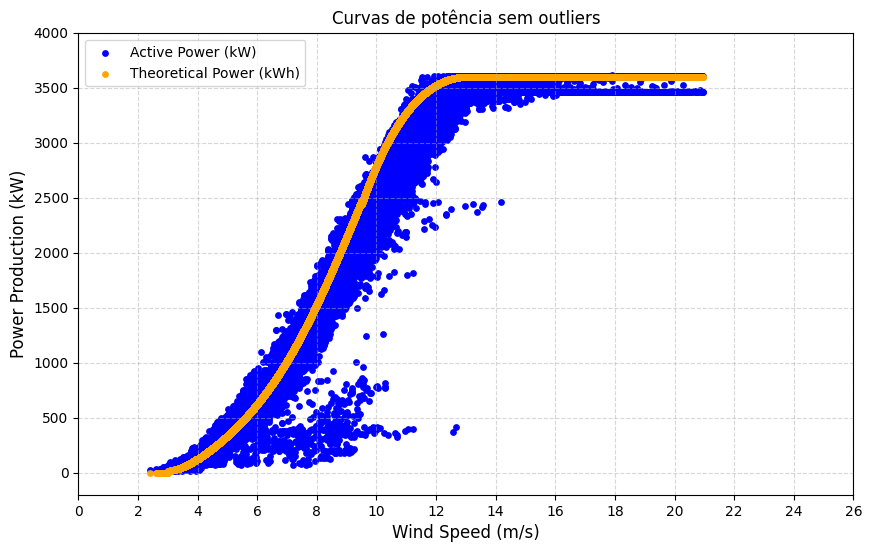

In [28]:
# Plotar curvas de potência para o aerogerador

# Preparar a figura
plt.figure(figsize=(10, 6))

# Potência ativa
plt.scatter(datasetFiltrado['Wind Speed (m/s)'], datasetFiltrado['Active Power (kW)'],
            label='Active Power (kW)', color='blue', marker="o", s=15)

# Potência teórica
plt.scatter(datasetFiltrado['Wind Speed (m/s)'], datasetFiltrado['Theoretical Power (kWh)'],
            label='Theoretical Power (kWh)', color='orange', marker="o", s=15)

# Exibir legenda
plt.legend()

# Nomenclatura dos eixos x e y
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Production (kW)', fontsize=12)
plt.title('Curvas de potência sem outliers')

# Definir explicitamente os limites do eixo x
xmin = 0  # Especificar o limite inferior
xmax = 26  # Especificar o superior
x_step = 2  # Especificar o passo
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0  # Especificar o limite inferior
ymax = 4000  # Especificar o superior
y_step = 500  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin-200, ymax)

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.show()

Através da curva de potência sem *outliers*, podemos notar que os valores de potência ativa (gerada) que não foram filtrados na manipulação do dataset estão bem mais próximos dos valores de potência teórica.

## 3.4. Influência da remoção dos outliers nos dados

Para analisar a nova distribuição dos dados após a remoção dos *outliers*, vamos plotar histogramas sobrepostos de distribuição de frequências.

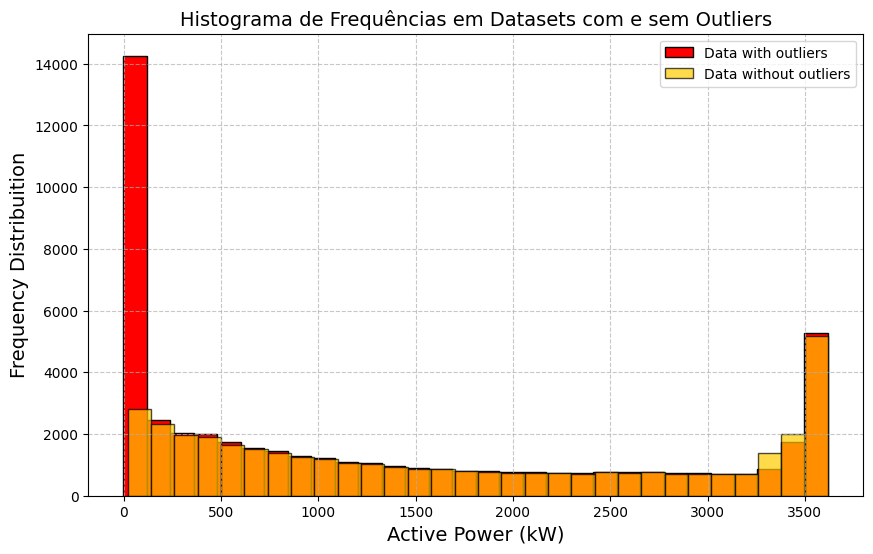

In [29]:
# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Plotar histograma para dataset com outliers
plt.hist(datasetTemporal['Active Power (kW)'], bins=30, color='red', alpha=1,
         label='Data with outliers', edgecolor='black')

# Plotar histograma para dataset sem outliers
plt.hist(datasetFiltrado['Active Power (kW)'], bins=30, color='#fc0', alpha=0.7,
         label='Data without outliers', edgecolor='black')

# Adicionar rótulos e título
plt.xlabel('Active Power (kW)', fontsize=14)
plt.ylabel('Frequency Distribuition', fontsize=14)
plt.title('Histograma de Frequências em Datasets com e sem Outliers', fontsize=14)
plt.legend()

# Adicionar grades (grid)
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o histograma
plt.show()

A região laranja do gráfico sinaliza a interseção entre os histogramas dos datasets com outliers (barra vermelha) e sem outliers (barra amarela). Vemos que há uma redução considerável da frequência de *outliers* de baixos valores, pois estes foram removidos do dataset, fazendo com que os dados ficassem menos dispersos.

Agora faremos um resumo estatístico para o dataset filtrado para entendermos qual foi o impacto dessa manipulação nos dados estatísticos. Para isso, precisamos agrupar os dados mensais para o novo dataset.

In [30]:
# Agrupar os dados por mês e realize a agregação necessária (por exemplo, média, soma, etc.)
resumoMensalSemOutliers = datasetFiltrado.groupby('Month').agg({'Active Power (kW)': ['mean', 'median'],
                                              'Wind Speed (m/s)': ['mean', 'median'],
                                              'Theoretical Power (kWh)': ['mean', 'median'],
                                              'Wind Direction (°)': ['mean', 'median']}).reset_index()

# Exiba o DataFrame resultante
print(resumoMensalSemOutliers)

        Month Active Power (kW)              Wind Speed (m/s)             \
                           mean       median             mean     median   
0  2018-01-01       2240.123344  2685.001953        10.613395  10.500000   
1  2018-02-01       1962.109659  1868.247009         9.617629   8.802019   
2  2018-03-01       2100.989429  2245.472900        10.177998   9.471620   
3  2018-04-01       1505.571090   932.308411         8.307097   7.035699   
4  2018-05-01       1513.878763  1278.436035         8.046906   7.812349   
5  2018-06-01       1579.812385  1476.828003         8.392667   8.213219   
6  2018-07-01       1065.230510   620.226074         7.080731   6.272809   
7  2018-08-01       1688.471415  1425.410034         8.637845   8.146570   
8  2018-09-01       1849.523624  1802.390991         8.878219   8.754924   
9  2018-10-01       1512.606580  1236.426453         8.124234   7.677040   
10 2018-11-01       2081.722569  2199.184937        10.003265   9.416845   
11 2018-12-0

Agora plotaremos os gráficos de linha, respectivamente, para as médias e medianas mensais para o dataset antes e depois da filtragem dos *outliers*.

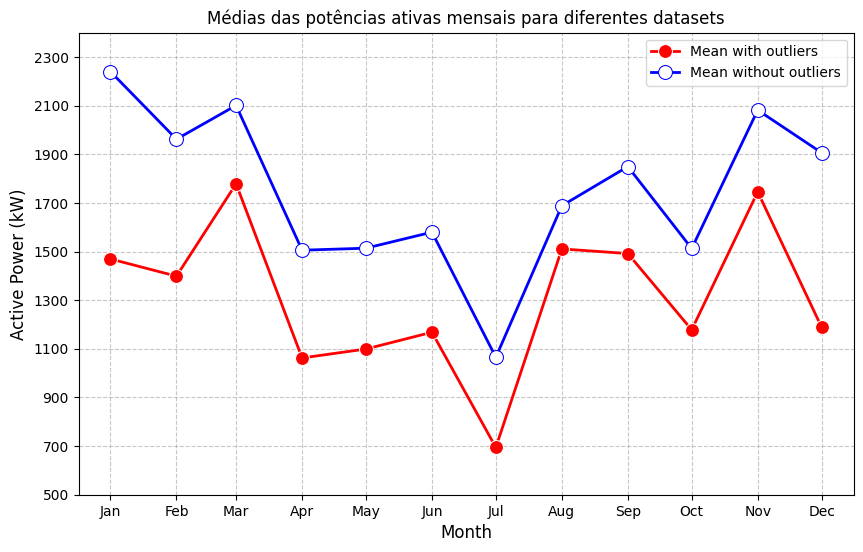

In [31]:
# Plotar o gráfico de linha usando seaborn das médias mensais da potência ativa do aerogerador no ano de 2018
# Comparação entre o dataset original e o dataset sem outliers
plt.figure(figsize=(10, 6))

# Linha da média no dataset original
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'mean'),
             label='Mean with outliers', color='red', marker="o", linewidth=2, markersize=10)

# Linha da média no dataset sem outliers
sns.lineplot(data=resumoMensalSemOutliers, x='Month', y=('Active Power (kW)', 'mean'),
             label='Mean without outliers', color='blue', marker="o",
             markeredgecolor='blue', markerfacecolor='white', linewidth=2, markersize=10)

# Nomenclatura dos eixos x e y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Médias das potências ativas mensais para diferentes datasets')

# Definir explicitamente os limites do eixo x
xmin = resumoMensal['Month'].min() - pd.to_timedelta('15 days')  # Subtrai 15 dias do mínimo
xmax = resumoMensal['Month'].max() + pd.to_timedelta('15 days')  # Adiciona 15 dias ao máximo
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10) # Definir tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 500  # Especificar o limite inferior
ymax = 2400  # Especificar o superior
y_step = 200  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin, ymax)

# Ajustar o formato do eixo x para exibir os nomes para cada mês do ano
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

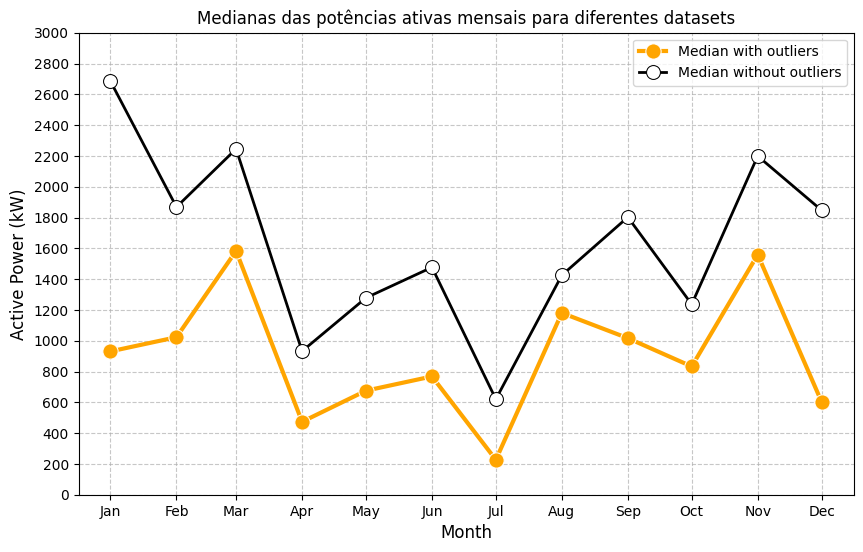

In [32]:
# Plotar o gráfico de linha usando seaborn das medianas mensais da potência ativa do aerogerador no ano de 2018
# Comparação entre o dataset original e o dataset sem outliers
plt.figure(figsize=(10, 6))

# Linha da mediana no dataset original
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'median'),
             label='Median with outliers', color='orange', marker="o", linewidth=3, markersize=11)

# Linha da mediana no dataset sem outliers
sns.lineplot(data=resumoMensalSemOutliers, x='Month', y=('Active Power (kW)', 'median'),
             label='Median without outliers', color='black', marker="o",
             markeredgecolor='black', markerfacecolor='white', linewidth=2, markersize=10)

# Nomenclatura dos eixos x e y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Medianas das potências ativas mensais para diferentes datasets')

# Definir explicitamente os limites do eixo x
xmin = resumoMensal['Month'].min() - pd.to_timedelta('15 days')  # Subtrai 15 dias do mínimo
xmax = resumoMensal['Month'].max() + pd.to_timedelta('15 days')  # Adiciona 15 dias ao máximo
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10) # Definir tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0 # Especificar o limite inferior
ymax = 3000  # Especificar o superior
y_step = 200  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin, ymax)

# Ajustar o formato do eixo x para exibir os nomes para cada mês do ano
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

De acordo com os gráficos das médias e medianas mensais, podemos notar que ambas as variáveis aumentaram em todos os meses para o dataset sem os *outliers*. Isso é uma indicação de que havia uma distribuição razoavelmente uniforme dos *outliers* ao longo do ano.

As médias mensais pós tratamento dos *outliers* mantiveram, ao longo do ano, um padrão similar ao dos dados não tratados. Para as medianas, a única excessão foi o mês de Janeiro, o que sugere uma quantidade maior de *outliers* nesse mês.

Na comparação mês a mês, antes e após o tratamento dos *outliers*, Janeiro e Dezembro apresentaram as maiores diferenças tanto para as médias, quanto para as medianas. Isso indica que esses meses possuem mais *outliers* do que os demais, o que provavelmente pode ter relação com condições meteorológicas específicas nessa época do ano.

Para ter uma visão global da influência da remoção dos *outliers* em outras medidas estatísticas, vamos produzir 2 novos datasets, antes e depois da manipulação, com os seguintes dados:

* Média
* Desvio padrão
* Percentil 25
* Percentil 50 (mediana)
* Percentil 75


Vamos criar datasets, antes e após a remoção dos outliers, respectivamente, com o resumo das principais medidas estatísticas.

In [33]:
# Reunir dados estatísticos antes do tratamento dos outliers
estatisticas = {
    'mean': datasetTemporal['Active Power (kW)'].mean(),
    'std': datasetTemporal['Active Power (kW)'].std(),
    '25th percentile': datasetTemporal['Active Power (kW)'].quantile(0.25),
    'median': datasetTemporal['Active Power (kW)'].median(),
    '75th percentile': datasetTemporal['Active Power (kW)'].quantile(0.75),
}

# Criar DataFrame
resumo_estatistico = pd.DataFrame(estatisticas, index=['Active Power (kW)'])

# Transpor o DataFrame para que as estatísticas se tornem colunas
resumo_estatistico = resumo_estatistico.T

# Exibir o novo DataFrame
print(resumo_estatistico)


                 Active Power (kW)
mean                   1307.684332
std                    1312.459242
25th percentile          50.677890
median                  825.838074
75th percentile        2482.507568


In [34]:
# Reunir dados estatísticos sem outliers (so)
estatisticas = {
    'mean': datasetFiltrado['Active Power (kW)'].mean(),
    'std': datasetFiltrado['Active Power (kW)'].std(),
    '25th percentile': datasetFiltrado['Active Power (kW)'].quantile(0.25),
    'median': datasetFiltrado['Active Power (kW)'].median(),
    '75th percentile': datasetFiltrado['Active Power (kW)'].quantile(0.75),
}

# Criar DataFrame
resumo_estatistico_so = pd.DataFrame(estatisticas, index=['Active Power (kW)'])

# Transpor o DataFrame para que as estatísticas se tornem colunas
resumo_estatistico_so = resumo_estatistico_so.T

# Exibir o novo DataFrame
print(resumo_estatistico_so)

                 Active Power (kW)
mean                   1744.570823
std                    1261.763468
25th percentile         549.767120
median                 1520.890015
75th percentile        3057.109009


Agora vamos criar o gráfico de barras para comparar todas medidas estatísticas na mesma figura.

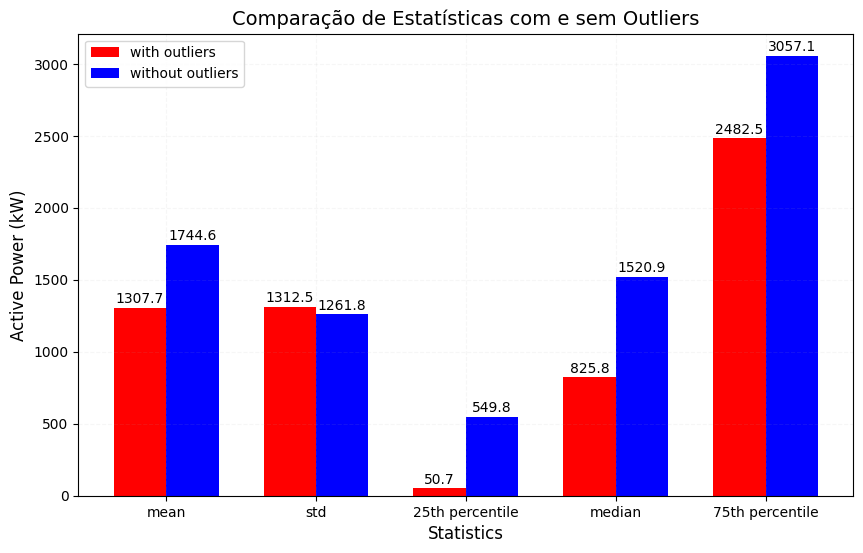

In [35]:
# Configurar barras
plt.figure(figsize=(10, 6))
barWidth = 0.35
r1 = range(len(resumo_estatistico))
r2 = [x + barWidth for x in r1]

# Criar o gráfico de barras
plt.bar(r1, resumo_estatistico['Active Power (kW)'], color='red', width=barWidth, label='with outliers')
plt.bar(r2, resumo_estatistico_so['Active Power (kW)'], color='blue', width=barWidth, label='without outliers')

# Adicionar rótulos às barras
plt.xlabel('Statistics', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Comparação de Estatísticas com e sem Outliers', fontsize=14)
plt.xticks([r + barWidth/2 for r in range(len(resumo_estatistico))], list(resumo_estatistico_so.index), fontsize=10)
plt.yticks(fontsize=10)

# Adicionar legenda
plt.legend()

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.1)

# Adicionar os valores máximos acima das barras no dataset com outliers
for i, value in enumerate(resumo_estatistico['Active Power (kW)']):
    plt.text(r1[i], value + 10, str(round(value, 1)), ha='center', va='bottom', fontsize=10, color='black')

# Adicionar os valores máximos acima das barras no dataset sem outliers
for i, value in enumerate(resumo_estatistico_so['Active Power (kW)']):
    plt.text(r2[i], value + 10, str(round(value, 1)), ha='center', va='bottom', fontsize=10, color='black')

# Exibir o gráfico
plt.show()

De acordo com o gráfico de barras, após a remoção dos *outliers*, houve um aumento da média e de todos os percentis. Isso já era esperado, uma vez que:

* Há uma grande quantidade de *outliers* com valores muito baixos (conforme mostrado no histograma). Dessa forma, uma vez removidos esses valores, a distribuição dos dados restantes agora é considerada a partir de valores mais elevados, ocasionando um aumento dos percentis. Além disso, como a média também sofre um aumento, já que esta é mais sensível à presença de valores extremos.

* Houve a redução da variabilidade dos dados, que é evidenciada pela redução no desvio padrão;

Apesar de ter havido uma leve redução no desvio padrão após a remoção dos *outliers*, este valor ainda está muito elevado. Isso confirma que a produção de energia nessa localidade é sazonal, provavelmente porque há uma alta variabilidade das condições de vento ao longo do ano.

## 3.5. Estruturação final do dataset

Com o dataset filtrado, vamos fazer a separação dos atributos da coluna 'Date/Time' em dia, mês, hora e minuto. Assim podemos analisar e quantificar se há alguma influência dessas variáveis de maneira separada no atributo target.

In [36]:
# Criar uma cópia de segurança do dataset antes das manipulações
datasetFiltradoSeparado = datasetFiltrado.copy()

In [37]:
# Converter a coluna 'Date/Time' do DataFrame para o tipo datetime, utilizando um formato específico de data e hora
datasetFiltradoSeparado['Date/Time']=pd.to_datetime(datasetFiltradoSeparado['Date/Time'],format='%d %m %Y %H:%M')

O próximo trecho de código está fazendo algumas operações no datasetFiltrado para ajustar e contar o número de ocorrências de semanas dentro de cada mês.

Essas operações são úteis para análises que requerem agrupamento ou comparação semanal dentro dos mesmos meses, especialmente quando não se deseja considerar uma quinta semana separada.

In [38]:
# Calcular o número da semana dentro do mês para cada data
datasetFiltradoSeparado['Week']=(datasetFiltradoSeparado['Date/Time'] - datasetFiltradoSeparado['Date/Time'].dt.to_period('M').dt.to_timestamp()).dt.days // 7 + 1

# Identificar e ajustar a 5a semana
filter=datasetFiltradoSeparado['Week'].loc[datasetFiltradoSeparado['Week']==5]
filter=filter-1

# Atualizar o número da semana no DataFrame original
datasetFiltradoSeparado['Week'].update(filter)

# Contar as ocorrências de cada semana
datasetFiltradoSeparado['Week'].value_counts()

4    11280
3     9736
2     9396
1     8427
Name: Week, dtype: int64

In [39]:
# Adicionar uma nova coluna 'Month' ao DataFrame
datasetFiltradoSeparado['Month']=datasetFiltradoSeparado['Date/Time'].dt.month

# Adicionar uma nova coluna 'Day' ao DataFrame
datasetFiltradoSeparado['Day']=datasetFiltradoSeparado['Date/Time'].dt.day

# Adicionar uma nova coluna 'Hour' ao DataFrame
datasetFiltradoSeparado['Hour']=datasetFiltradoSeparado['Date/Time'].dt.hour

# Remover a coluna 'Date/Time' do DataFrame
datasetFiltradoSeparado.drop(columns=['Date/Time'],inplace=True)

In [40]:
# Identificar e somar o número de valores ausentes (NA) em cada coluna do DataFrame
datasetFiltradoSeparado.isna().sum()

Month                      0
Active Power (kW)          0
Wind Speed (m/s)           0
Theoretical Power (kWh)    0
Wind Direction (°)         0
Week                       0
Day                        0
Hour                       0
dtype: int64

Através dessa manipulação, podemos posteriormente analizar a importância dos atributos 'Week', 'Day' e 'Hour' na variável target ('Active Power').

## 3.6. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste, uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos.

Usaremos 80% do conjunto de dados para modelagem (training set) e guardaremos 20% para teste (test set), usando a estratégia train-test-split.

Primeiramente, iremos sinalizar quais são as colunas de features e qual é a coluna target. Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados).

Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: features e target para o test set e features e target para o training set. Faremos experimentação no dataset original e também no dataset sem outliers.

In [41]:
# Selecionar as colunas de interesse no dataset
features_selecionadas = ['Wind Speed (m/s)', 'Theoretical Power (kWh)',
                         'Wind Direction (°)', 'Week', 'Month', 'Hour', 'Day']
target = ['Active Power (kW)']

# Converter DataFrame do pandas para arrays do NumPy
X = datasetFiltradoSeparado[features_selecionadas]
y = datasetFiltradoSeparado[target]

# Separar conjunto de dados para treino e teste
test_size = 0.20
seed = 7
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=seed)

In [42]:
# Imprimir os datasets produzidos
print("The Shape of X_train is :",X_train.shape)
print("The Shape of y_train is :",y_train.shape)
print("The Shape of X_test is :",X_test.shape)
print("The Shape of y_test is :",y_test.shape)

The Shape of X_train is : (31071, 7)
The Shape of y_train is : (31071, 1)
The Shape of X_test is : (7768, 7)
The Shape of y_test is : (7768, 1)


## 3.7. Pipeline de pré-processamento

Este pipeline utiliza o StandardScaler para padronizar atributos numéricos, removendo a média e escalando para a variância da unidade. A padronização é importante antes de aplicar muitos algoritmos de aprendizado de máquina porque eles se comportam melhor quando os atributos estão na mesma escala.

In [43]:
# Padronizar atributos numéricos
num_pipeline = make_pipeline(StandardScaler())

# Aplicar transformações específicas às colunas selecionadas
preprocessing = ColumnTransformer([('num', num_pipeline, features_selecionadas)])

Ao aplicar o pré-processamento definido pelo ColumnTransformer no conjunto de treino e no seu conjunto de teste, estamos transformando os dados de acordo com os pipelines especificados para a coluna numérica.

In [44]:
# Mostrar X_train
X_train

,Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°),Week,Month,Hour,Day
12937,6.899790,971.508370,49.299351,2,10,17,9
18883,8.214645,1655.205882,37.613911,2,7,19,14
32305,18.079149,3600.000000,191.158005,1,1,19,2
34811,13.614220,3600.000000,49.106689,3,4,22,18
9226,5.827533,568.342841,225.064896,3,11,0,20
...,...,...,...,...,...,...,...
34140,13.832600,3600.000000,214.673096,3,3,20,18
13927,7.300403,1157.164836,57.841900,1,4,18,7
919,3.674518,73.982554,15.877990,4,8,8,30
38467,11.839940,3494.836997,195.005905,2,12,22,14


In [45]:
# Ajustar o transformador aos dados de treino e então transformar os dados de treino com base nesses parâmetros
X_1=pd.DataFrame(preprocessing.fit_transform(X_train))

# Aplicar as transformações aprendidas com o conjunto de treino ao conjunto de teste, sem ajustar novamente os parâmetros
X_1_test=pd.DataFrame(preprocessing.transform(X_test))

A utilização do método fit_transform para o conjunto de treino e transform para o conjunto de teste garante que as transformações aplicadas ao conjunto de teste são baseadas nos parâmetros aprendidos a partir do conjunto de treino, mantendo a consistência e evitando o vazamento de dados.

In [46]:
# Mostrar X_1 gerado no procedimento
X_1

,0,1,2,3,4,5,6
0,-0.550644,-0.707202,-0.765230,-0.547683,1.009945,0.753063,-0.767256
1,-0.189258,-0.180211,-0.902356,-0.547683,0.108463,1.039044,-0.186702
2,2.521985,1.318828,0.899459,-1.440077,-1.694502,1.039044,-1.580032
3,1.294806,1.318828,-0.767491,0.344711,-0.793020,1.468016,0.277742
4,-0.845352,-1.017960,1.297351,0.344711,1.310439,-1.677778,0.509963
...,...,...,...,...,...,...,...
31066,1.354827,1.318828,1.175405,0.344711,-1.093514,1.182035,0.277742
31067,-0.440536,-0.564098,-0.664984,-1.440077,-0.793020,0.896053,-0.999478
31068,-1.437105,-1.399011,-1.157424,1.237105,0.408957,-0.533853,1.671072
31069,0.807148,1.237769,0.944614,-0.547683,1.610933,1.468016,-0.186702


# 4. Modelagem e treinamento

## 4.1. Modelagem inicial e avaliação de atributos

Sabemos que X_1 contém as features já processadas, e que y_train contém as variáveis-alvo correspondentes do conjunto de treino original. Assim, as features processadas serão divididas em dois conjuntos: um para treinar o modelo (X_train_1) e outro para validar o modelo (X_valid). As variáveis-alvo correspondentes a X_1, também serão divididas em conjuntos de treino (y_train_1) e validação (y_valid).

Essa prática é essencial para testar a capacidade do modelo de generalizar para novos dados, ou seja, dados que não foram usados durante o treinamento. Avaliando o modelo no conjunto de validação, podemos identificar se ele está ou não se ajustando demais aos dados de treinamento (overfitting) e ajustar os parâmetros do modelo conforme necessário para melhorar seu desempenho.

In [47]:
# Dividir o conjunto de dados em subconjuntos de treino e validação
X_train_1, X_valid, y_train_1, y_valid = train_test_split(X_1, y_train, test_size=test_size, random_state=seed)

Para avaliar a importância dos atributos do dataset, vamos treinar um modelo de regressão usando o algoritmo de Floresta Aleatória. A escolha desse tipo de algoritmo como ponto de partida para problemas de regressão pode ser justificada pelas seguintes razões:

1. **Facilidade de Uso**: esses modelos requerem muito menos ajuste de hiperparâmetros em comparação com outros algoritmos.

2. **Desempenho**: oferecem um bom desempenho e são menos propensas a overfitting do que árvores de decisão isoladas, especialmente em conjuntos de dados com muitas características.

3. **Interpretabilidade**: oferecem métricas úteis, como a importância das características, que ajudam a entender quais variáveis mais influenciam as previsões do modelo.

4. **Não Linearidade**: podem capturar relações não lineares e complexas entre as características sem a necessidade de transformar explicitamente as variáveis.

5. **Capacidade de Generalização**: tendem a generalizar bem para dados não vistos.

Dadas essas razões, esse algoritmo será utilizado como um modelo inicial para comparar o desempenho com outros algoritmos mais complexos ou ajustados. Ele servirá como uma linha de base para demonstrar a necessidade de métodos mais sofisticados.

In [48]:
# Criar e treinar um regressor de Floresta Aleatória
model = RandomForestRegressor(random_state= seed)
model.fit(X_train_1, y_train_1)

# Obter a importância das features em questão
feature_importance = model.feature_importances_

# Criar um DataFrame para associar os atributos com suas importâncias
# Assumindo que 'features_selecionadas' seja a lista de nomes das características após transformação
feature_importance_df = pd.DataFrame({'Feature': features_selecionadas, 'Importance': feature_importance})

# Ordenar features por importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [49]:
# Mostrar DataFrame com valores de importâncias
feature_importance_df

,Feature,Importance
0,Wind Speed (m/s),0.532661
1,Theoretical Power (kWh),0.453024
2,Wind Direction (°),0.005491
4,Month,0.003549
6,Day,0.002917
5,Hour,0.001925
3,Week,0.000433


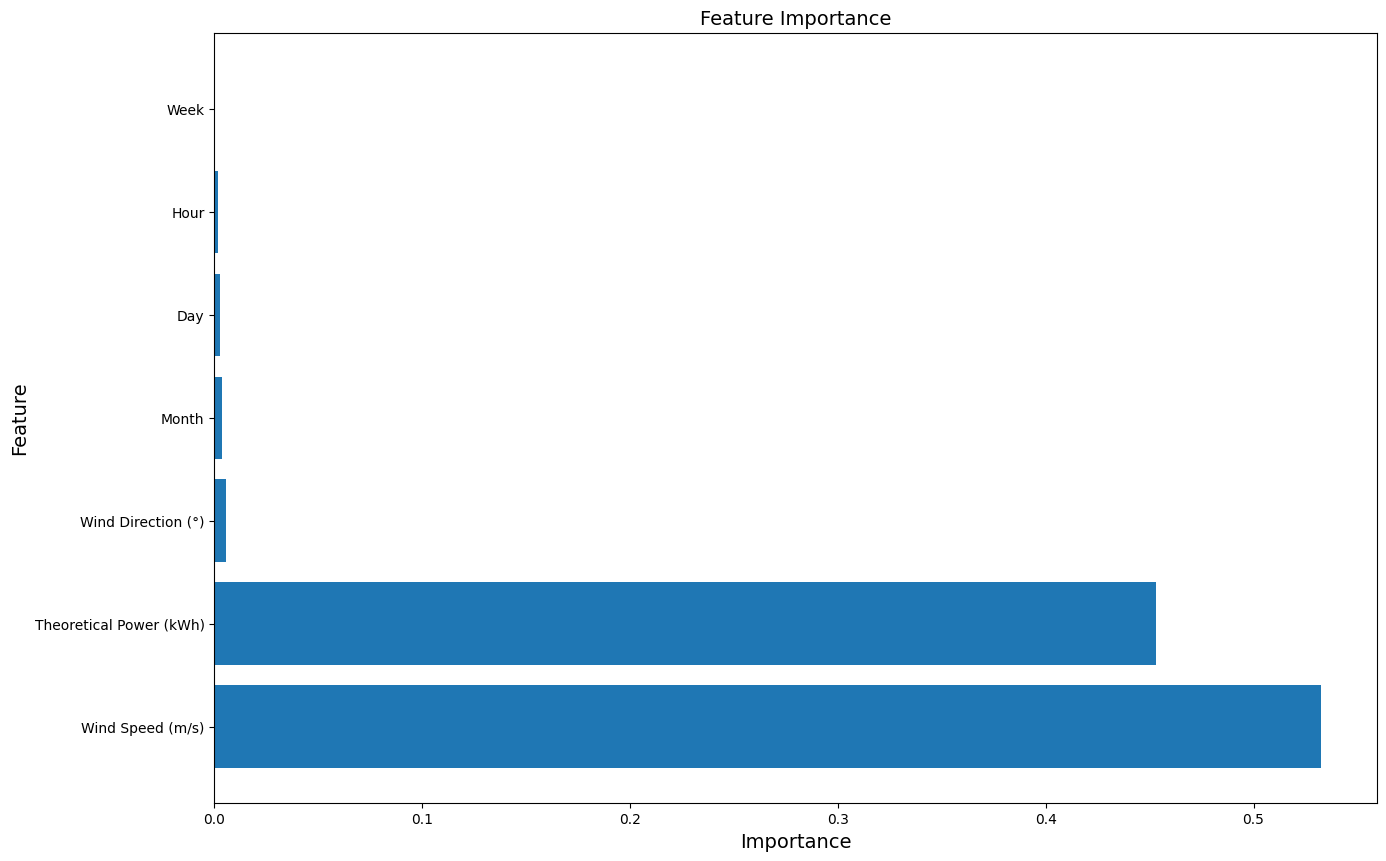

In [50]:
# Plotar gráfico de barras horizontal com a importância das features

# Configurar tamanho da figura para o gráfico
plt.figure(figsize=(15, 10))

# Criar um gráfico de barras horizontal
# O eixo Y mostra os nomes das features e o eixo X a importância
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])

# Adicionar rótulo ao eixo X para indicar que ele representa a importância das features
plt.xlabel('Importance', fontsize=14)

# Adicionar rótulo ao eixo Y para indicar que ele representa os nomes das features
plt.ylabel('Feature', fontsize=14)

# Adicionar título ao gráfico
plt.title('Feature Importance', fontsize=14)

# Exibir o gráfico
plt.show()

De acordo com o resultado anterior, podemos avaliar que os atributos 'Wind Speed' e 'Theoretical Power' são os mais relevantes para a variável target ('Active Power'). Os demais atributos possuem uma importância bem reduzida.

Dessa forma, um modelo mais simples, como regressão linear, pode ser mais adequado e mais fácil de interpretar. Para ter um parâmetro de comparação, também pode ser útil experimentar modelos mais complexos, como o SVM, ou mesmo outros tipos algoritmos de árvores de decisão. Modelos baseados em gradient boosting, como XGBoost, XGBRegressor ou Adaboosting, podem oferecer melhor desempenho para esse problema.

Portanto, vamos testar alguns tipos de algoritmos de regressão para compararmos as respectivas métricas de avaliação na próxima seção.

## 4.2. Seleção de algoritmos

De acordo com o proposto anteriormente, vamos utilizar uma lista de algoritmos de regressão para avaliar o desempenho de cada um deles nos dados de teste. Para cada modelo, o vamos calcular e armazenar duas métricas de desempenho: o coeficiente de determinação (R²) e a raiz do erro quadrático médio (RMSE).

In [51]:
# Lista de modelos para avaliação
models = [
    GradientBoostingRegressor(random_state=seed),
    SVR(),
    RandomForestRegressor(random_state=seed),
    LinearRegression(),
    ExtraTreesRegressor(random_state=seed),
    AdaBoostRegressor(random_state=seed),
    DecisionTreeRegressor(random_state=seed),
    XGBRegressor(random_state=seed),
    XGBRFRegressor(random_state=seed)
]

# Inicialização de listas para armazenar os resultados
model_name = []
r2score = []
rmse = []

# Loop para treinar cada modelo e coletar métricas de desempenho
for model in models:
    # Treinar o modelo com o conjunto de treinamento
    model.fit(X_1, y_train)
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_1_test)
    # Armazenar o nome do modelo
    model_name.append(model.__class__.__name__)
    # Calcular e armazenar o R2 Score
    r2score.append(r2_score(y_test, y_pred) * 100)
    # Calcular e armazenar o RMSE
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))

In [52]:
# Criar um DataFrame pandas para armazenar os resultados
models_df = pd.DataFrame({
    "Model Name": model_name,
    "R2 Score (%)": r2score,
    "RMSE": rmse
})

# Exibir os resultados
print(models_df.sort_values(by="R2 Score (%)", ascending=False))

                  Model Name  R2 Score (%)        RMSE
7               XGBRegressor     99.521670   87.469805
4        ExtraTreesRegressor     99.044856  123.602922
2      RandomForestRegressor     99.029462  124.595013
0  GradientBoostingRegressor     98.700287  144.184333
8             XGBRFRegressor     98.337971  163.047312
6      DecisionTreeRegressor     98.155759  171.752550
3           LinearRegression     97.818850  186.782891
5          AdaBoostRegressor     95.854676  257.497822
1                        SVR     93.937156  311.409976


Para melhorar visibilidade, vamos comparar os resultados através de um gráfico.

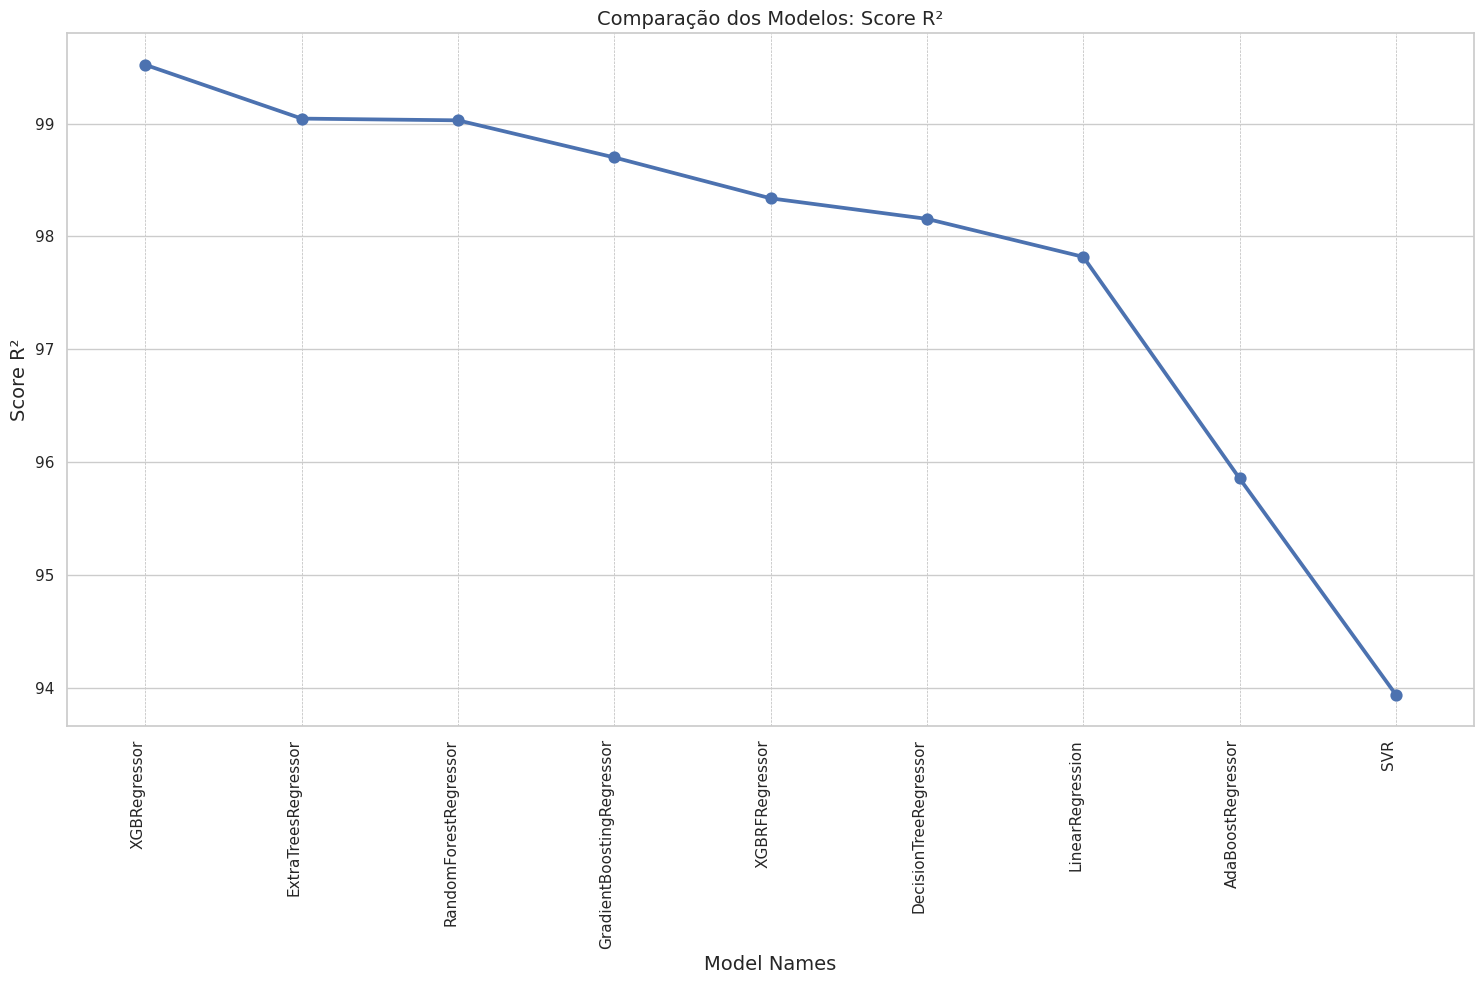

In [53]:
# Ordenar os modelos pelo R2 Score (%) de forma decrescente
models_df_sorted = models_df.sort_values('R2 Score (%)', ascending=False)

# Definindo um tema do Seaborn para estética
sns.set_theme(style="whitegrid")

# Criando a figura e definindo seu tamanho
plt.figure(figsize=(15, 10))

# Criando um gráfico de pontos para comparação dos modelos baseado no R2 Score
sns.pointplot(x='Model Name', y='R2 Score (%)', data=models_df_sorted, join=True)

# Rotacionando os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=90, ha='right')

# Adicionando rótulos aos eixos e um título ao gráfico
plt.xlabel('Model Names', fontsize=14)
plt.ylabel('Score R²', fontsize=14)
plt.title('Comparação dos Modelos: Score R²', fontsize=14)

# Adicionando linhas de grade verticais para melhor visualização
plt.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)

# Ajustando layout para não cortar rótulos
plt.tight_layout()

# Exibindo o gráfico
plt.show()

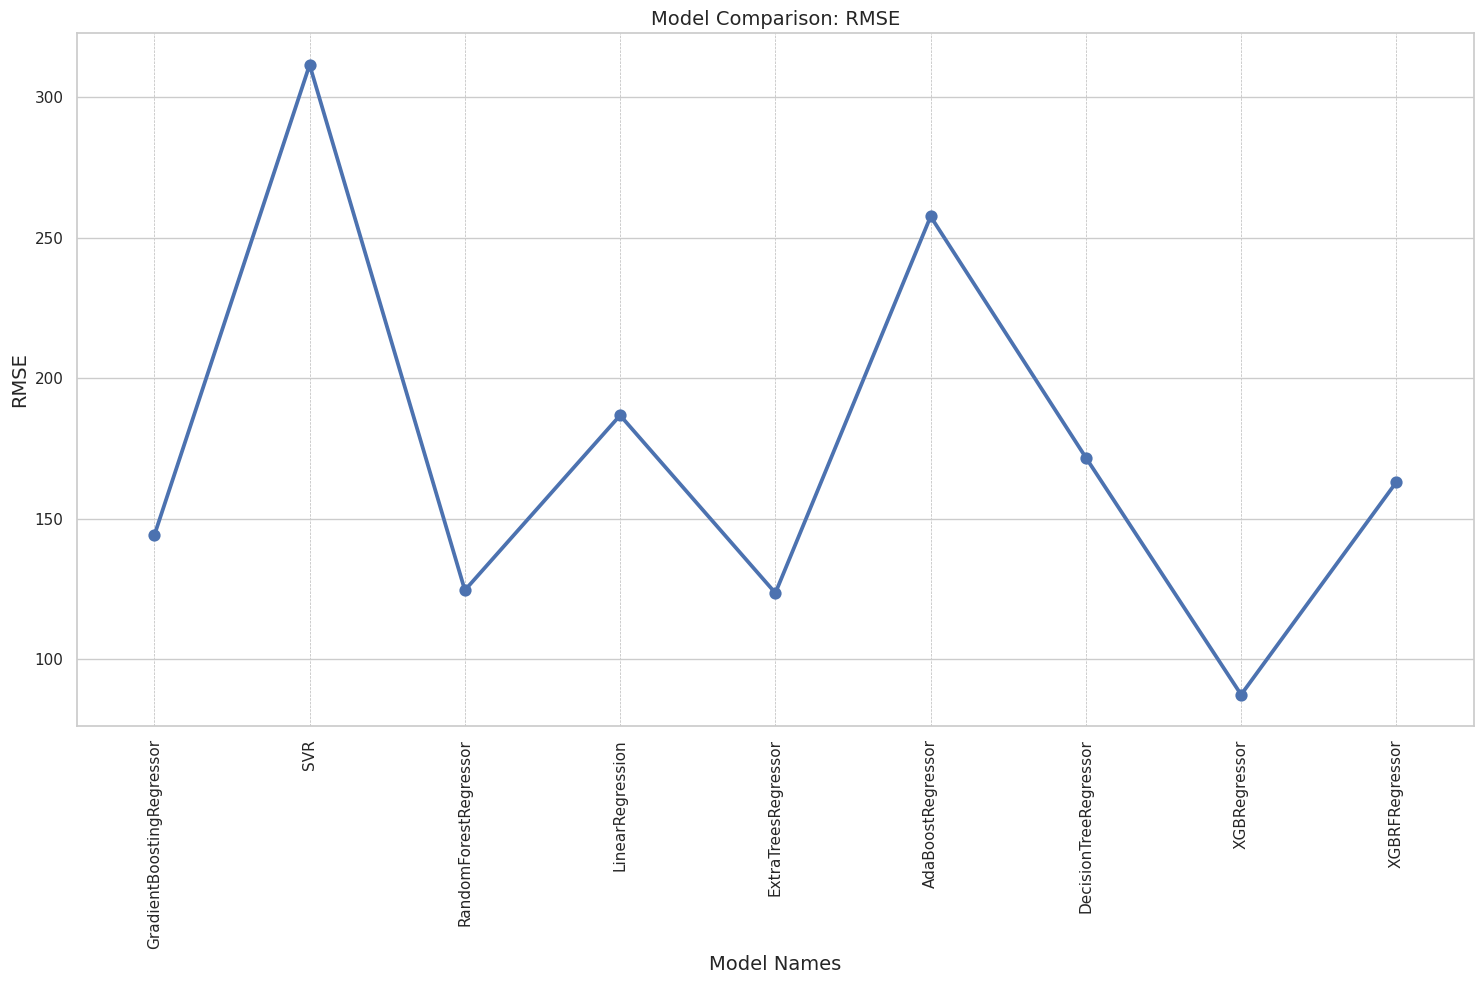

In [54]:
# Configurando o tamanho da figura para o gráfico
plt.figure(figsize=(15, 10))

# Definindo o tema do Seaborn para melhorar a estética do gráfico
sns.set_theme(style="whitegrid")

# Utilizando o Seaborn para criar um gráfico de pontos
sns.pointplot(x='Model Name', y='RMSE', data=models_df)

# Rotacionando os rótulos do eixo X para garantir que os nomes dos modelos sejam legíveis
plt.xticks(rotation=90)

# Adicionando rótulos aos eixos e um título ao gráfico
plt.xlabel('Model Names', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Model Comparison: RMSE', fontsize=14)

# Adicionando linhas de grade verticais para melhor visualização
plt.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)

# Ajustando o layout da figura para garantir que nenhum elemento do gráfico seja cortado
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Pelos gráficos, o maior valor do coeficiente de determinação (R²) com o menor erro médio quadrático foram obtidos pelo modelo XGBRegressor. Com essa informação, vamos salvar o modelo e, em seguida, podemos iniciar um refinamento dos hiperparâmetros.

In [55]:
# Salvar o modelo final
final_model = XGBRegressor(random_state=seed)

## 4.3. Refinamentos dos hiperparâmetros

Essa etapa focará em ajustar as melhores combinações dos hiperparâmetros para otimização do modelo, com base no seu desempenho. Para isso, utilizaremos uma estratégia de grid search.

In [56]:
# Definindo um conjunto de hiperparâmetros para otimização do XGBRegressor
param_grid = {
    # Número de árvores de boosting a serem criadas
    # Mais árvores aumentam a precisão, mas também o risco de overfitting
    'n_estimators': [100, 500, 900, 1100, 1500],

    # Profundidade máxima de cada árvore
    # Limita a complexidade do modelo, controlando o overfitting
    'max_depth': [2, 3, 5, 10, 15],

    # Taxa de aprendizado, ou "shrinkage"
    # Reduz a contribuição de cada árvore para evitar overfitting
    'learning_rate': [0.05, 0.1, 0.15, 0.20],

    # Peso mínimo necessário nas folhas da árvore
    # Ajuda a prevenir o overfitting em dados com desbalanceamento significativo
    'min_child_weight': [1, 2, 3, 4],

    # Valor inicial das previsões
    # Pode ser ajustado para melhorar a baseline do modelo
    'base_score': [0.25, 0.5, 0.75, 1],
}

In [57]:
# Inicializando o objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=final_model,  # O modelo a ser otimizado
    param_distributions=param_grid,  # O dicionário de hiperparâmetros a serem testados
    n_iter=50,  # Número de iterações/configurações de hiperparâmetros a serem testadas
    scoring='r2',  # Métrica de desempenho a ser usada para avaliar o modelo
    n_jobs=-1,  # Número de trabalhos a serem executados em paralelo (-1 significa usar todos os processadores)
)

O uso de `RandomizedSearchCV` permite uma busca eficiente por combinações ideais dos hiperparâmetros, onde podemos testar uma variedade de combinações de maneira aleatória dentro de um conjunto predefinido.

A busca inclui uma avaliação final através da validação cruzada, que ajuda a garantir que o modelo final seja confiável e generalizável para novos dados, sem ser excessivamente ajustado às peculiaridades dos dados de treinamento. Ao fixar um estado aleatório, garantimos também que o processo possa ser replicado exatamente, assegurando a confiabilidade nos resultados obtidos.

In [58]:
# Ajustar o objeto RandomizedSearchCV aos dados de treinamento
# Isso inicia a busca pelos melhores hiperparâmetros do modelo especificado anteriormente
random_search.fit(X_1, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=7, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   scoring='r2')

Após completar a busca pelos hiperparâmetros, podemos inspecionar quais foram os melhores hiperparâmetros encontrados e qual foi o melhor coeficiente de determinação (Score R²) de desempenho obtido com essa combinação.

In [59]:
# Obter os melhores hiperparâmetros resultantes da busca
best_params = random_search.best_params_
# Obter o melhor score (desempenho) associado aos melhores hiperparâmetros
# Este score é a média dos scores de validação cruzada para o melhor conjunto de hiperparâmetros
best_score = random_search.best_score_

# Exibir os melhores hiperparâmetros e o melhor score R² obtido
print('Melhores Parâmetros:', best_params)
print('Melhor Score R²:', best_score)

Melhores Parâmetros: {'n_estimators': 1500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'base_score': 1}
Melhor Score R²: 0.9955394322044633


## 4.4. Avaliação de resultados

Nessa etapa, vamos treinar o modelo com a melhor combinação de hiperparâmetros encontrada na busca aleatória.

In [60]:
# Treinando o modelo XGBRegressor com os melhores hiperparâmetros
# O operador ** é usado para desempacotar os hiperparâmetros do dicionário diretamente nos argumentos do modelo.
optmized_model = XGBRegressor(**best_params)

# Ajustando o modelo otimizado aos dados de treinamento.
# X_1 são os dados de características de treinamento já pré-processados,
# e y_train são os valores alvo correspondentes.
optmized_model.fit(X_1, y_train)

# Utilizando o modelo treinado para fazer previsões no conjunto de dados de teste.
# X_1_test são os dados de características de teste pré-processados.
y_pred = optmized_model.predict(X_1_test)

# Convertendo y_test para um array NumPy
y_test_1 = y_test.to_numpy()

In [61]:
# Calculando o R² Score com base nas previsões do modelo e os valores reais do conjunto de teste
score_r2 = r2_score(y_test_1, y_pred)

# Exibindo o R² Score para fornecer uma medida da qualidade do modelo
# Um valor de R² mais próximo de 1 indica um modelo que explica bem a variabilidade dos dados
print('Score R²:', score_r2)

Score R²: 0.9962029343967297


Como esperado, o coeficiente de determinação R² obtido para o modelo otimizado foi ligeiramente maior (0.996) em relação à situação antes da otimização (0.995). Isso comprova a importância da otimização dos hiperparâmetros na busca aleatória. Nesse caso, o valor do coeficiente de determinação já era alto e a melhora não foi tão significativa. Em outros casos, essa operação pode trazer mehorias cruciais para o modelo em questão.

## 4.5. Validação cruzada

Para analisar melhor a variação dos valores do coeficiente de determinação, vamos executar a validação cruzada para 20 folds, para fazer uma estimativa robusta do desempenho do modelo para novos dados.

In [62]:
# Executando a validação cruzada no conjunto de teste
# Esta operação usa o modelo já otimizado (optmized_model), aplicando-o ao conjunto de teste (X_1_test, y_test)
# para avaliar sua performance utilizando a métrica R² em 20 folds (cv=20)
cross_val_results = cross_val_score(optmized_model, X_1_test, y_test, scoring='r2', cv=20)

# Exibindo os scores de validação cruzada obtidos para cada fold
# Cada valor representa o R² Score do modelo em uma partição específica do conjunto de teste
print("Scores de Validação Cruzada (R²):", cross_val_results)
print("O valor máximo de (R²) é:", cross_val_results.max())

Scores de Validação Cruzada (R²): [0.99347812 0.98689687 0.99044514 0.9884613  0.99191542 0.99552194
 0.99481048 0.99278012 0.99517813 0.99424156 0.99316344 0.99255936
 0.99181748 0.99128767 0.99554179 0.99023717 0.98560388 0.99374277
 0.99454458 0.99460846]
O valor máximo de (R²) é: 0.9955417879826116


Para uma comparação visual, vamos plotar um gráfico com os valores de R² para todas as folds.

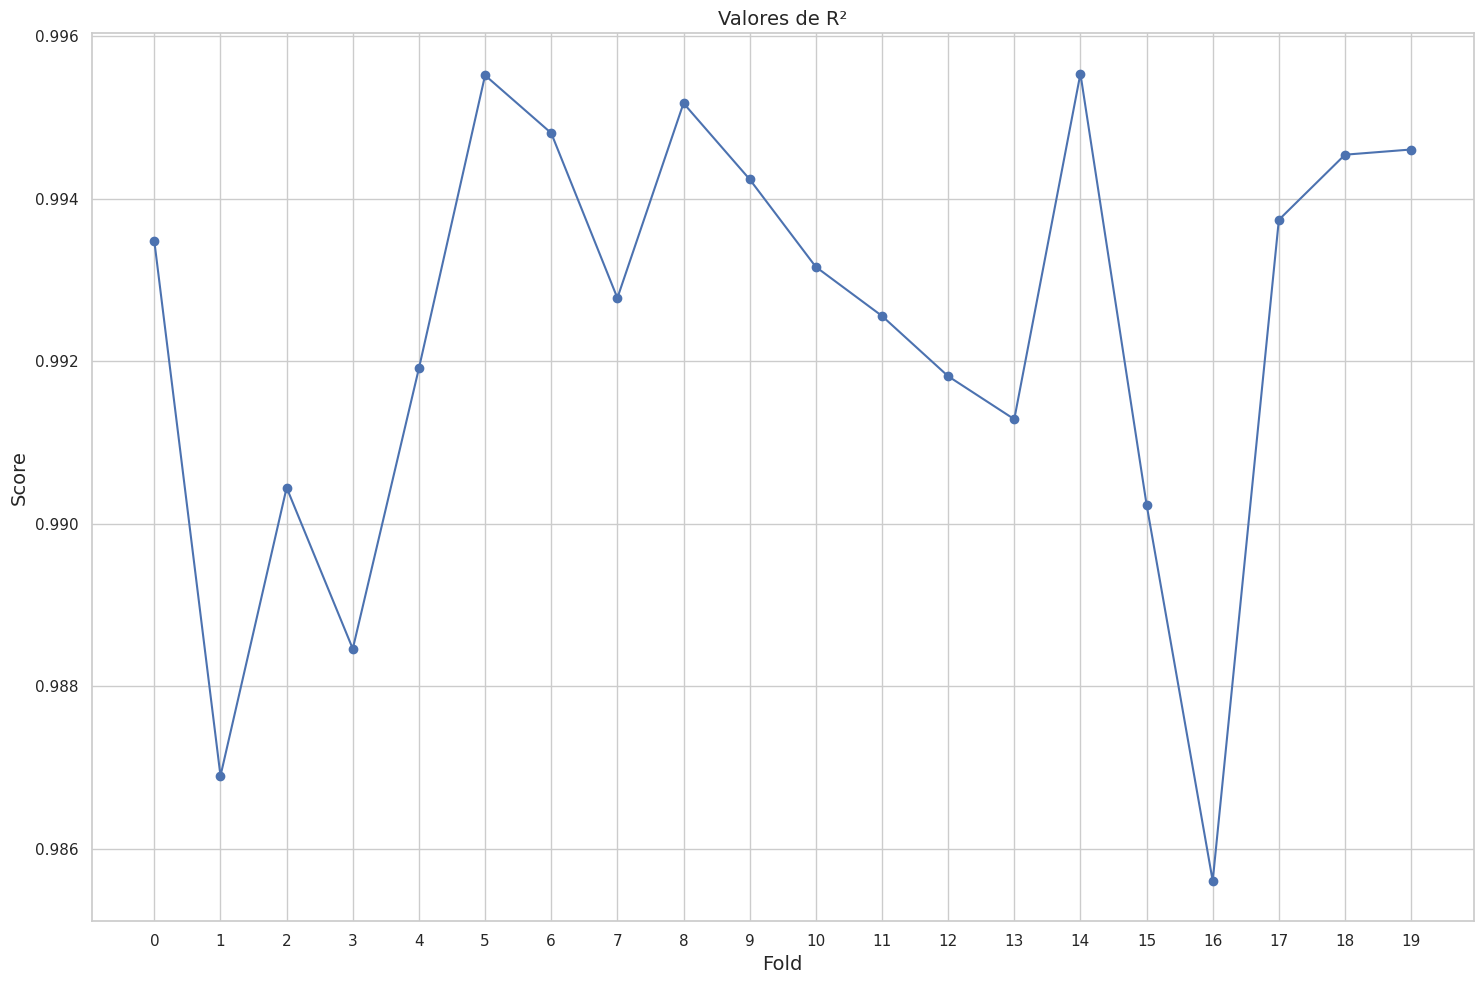

In [63]:
# Iniciando a criação da figura com dimensões específicas
plt.figure(figsize=(15, 10))

# Plotando os scores de validação cruzada
plt.plot(cross_val_results, marker='o', linestyle='-', color='b')

# Adicionando rótulos aos eixos e um título ao gráfico
plt.title("Valores de R²", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Fold", fontsize=14)

# Configurando os ticks do eixo X para corresponder ao número de folds
plt.xticks(np.arange(0, len(cross_val_results)))

# Ajustando o layout para assegurar que nada seja cortado
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Para novos dados, o maior valor para coeficiente de determinação obtido (0.995) foi ligeiramente menor em relação à situação anterior, onde o modelo utilizou parâmetros otimizados (0.996). Essa situação é esperada, tendo em vista que os modelos que têm boa capacidade de generalização podem apresentar alguma variação desse tipo.

Como trata-se de uma variação muito pequena, isso é forte indicativo de que o modelo mantém um alto grau de generalização mesmo após a validação cruzada com novos dados de teste, e de que também o mesmo não está sobreajustado aos dados de treinamento (overfitting).

## 4.6. Comparação dos resultados teóricos e modelados

Com o objetivo de fazer comparações entre os dados previstos pelo modelo, os dados teóricos esperados e os dados medidos, vamos criar um novo dataset.

In [64]:
# Criando um DataFrame com os valores reais de 'Active Power (kW)'de 'y_test'
Dataset_new = pd.DataFrame({'Active Power (kW)': y_test.reset_index(drop=True).values.ravel()})

# Adicionando as previsões do modelo ao DataFrame
# 'y_pred' é convertido para uma Series do pandas para alinhar corretamente com o índice de 'data_new'.
Dataset_new['Predictions'] = pd.Series(y_pred, index=Dataset_new.index)

# Exibindo as primeiras linhas do novo DataFrame para verificação
Dataset_new.head()

,Active Power (kW),Predictions
0,1400.293945,1307.328613
1,719.810791,700.995361
2,623.004517,552.151855
3,2085.188965,2103.518555
4,820.673279,786.106262


In [65]:
# Adicionar as colunas 'Theoretical Power (kWh)' e 'Wind Speed (m/s)' de 'X_test' ao Dataset 'Dataset_new', garantindo que os índices estejam alinhados
Dataset_new["Theoretical Power (kWh)"] = X_test["Theoretical Power (kWh)"].reset_index(drop=True)[:len(Dataset_new)]
Dataset_new["Wind Speed (m/s)"] = X_test["Wind Speed (m/s)"].reset_index(drop=True)[:len(Dataset_new)]

# Mostrar primeiras linhas do dataset gerada
Dataset_new.head()

,Active Power (kW),Predictions,Theoretical Power (kWh),Wind Speed (m/s)
0,1400.293945,1307.328613,1435.224909,7.831850
1,719.810791,700.995361,816.988662,6.528004
2,623.004517,552.151855,607.358458,5.947311
3,2085.188965,2103.518555,2536.094788,9.625121
4,820.673279,786.106262,919.688121,6.779374


Para visualizar e comparar a qualidade dos resultados, vamos plotar um gráfico com as previsões do modelo para o 'Active Power', os valores medidos da mesma variável e os seus valores teóricos esperados ('Theoretical Power'). Para isso vamos usar os dados do novo dataset (Dataset_new).

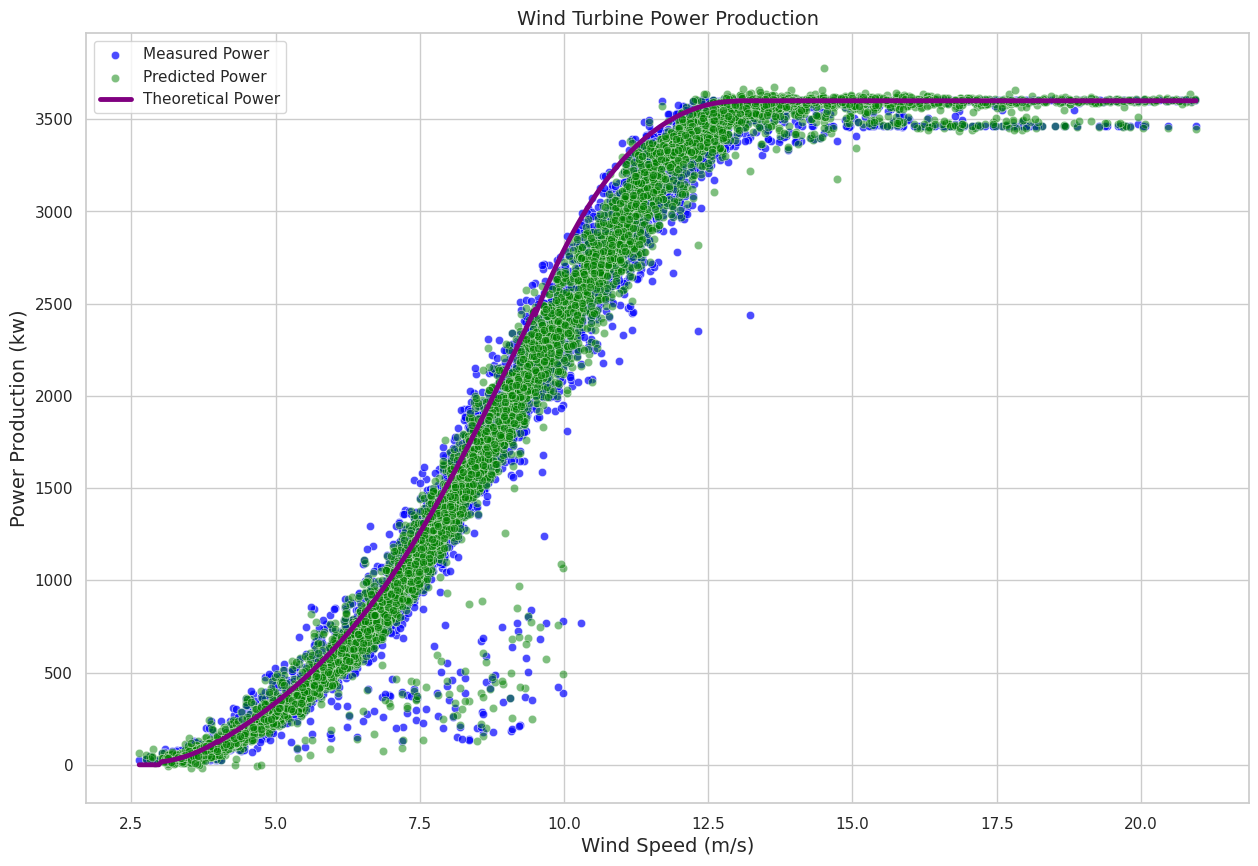

In [66]:
# Configurando o tamanho da figura para o gráfico
plt.figure(figsize=(15, 10))

# Criando um gráfico de dispersão para a produção de energia real
sns.scatterplot(x=Dataset_new['Wind Speed (m/s)'],
                y=Dataset_new['Active Power (kW)'],
                alpha=0.7,  # Opacidade dos pontos
                label='Measured Power',  # Legenda
                color='blue')  # Cor dos pontos

# Criando um segundo gráfico de dispersão para as previsões de produção de energia
sns.scatterplot(x=Dataset_new['Wind Speed (m/s)'],
                y=Dataset_new['Predictions'],
                alpha=0.5,  # Opacidade dos pontos
                label='Predicted Power',  # Legenda
                marker='o',  # Forma dos marcadores
                color='green')  # Cor dos pontos

# Adicionando um gráfico de linha para a produção de energia teórica
sns.lineplot(x=Dataset_new['Wind Speed (m/s)'],
             y=Dataset_new["Theoretical Power (kWh)"],
             label='Theoretical Power',  # Legenda
             color='purple', # Cor da linha
             linewidth=3.5)  # Espessura da linha

# Adicionando título e rótulos aos eixos
plt.title('Wind Turbine Power Production', fontsize=14)
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power Production (kw)', fontsize=14)

# Exibindo a legenda
plt.legend()

# Ajustando o layout para garantir uma visualização adequada e exibir o gráfico
#plt.tight_layout()
plt.show()

Através do gráfico, podemos notar que previsões acompanham com bastante proximidade os valores medidos, o que indica que o modelo de predição tem um bom ajuste e uma boa capacidade de generalização.

Os pontos do gráfico que não acompanham os valores teóricos esperados foram deixados após o pré-processamento dos dados, pois podem estar associados operações em baixas velocidades de vento baixas que podem representar condições operacionais anormais. Como o modelo foi treinado com a presença desses pontos, ele aprendeu a prever valores mais próximos à média para minimizar o erro global, o que é comum em técnicas de regressão.

#5. Conclusões

Com base nesse projeto, foi possível verificar que:

* Os dados contidos no dataset Wind Power SCADA apresentaram, em geral, boa qualidade.

* As inúmeras visualizações aplicadas para os atributos do dataset escolhido serviram para a construção de um entendimento global dos dados. A partir disso, foi possível traças estratégias de manipulação do dataset que foram realizadas em etapas posteriores.

* A abordagem de tratamento de *outliers* deve ser guiada pelo conhecimento do domínio, pelos objetivos da análise e pelas características específicas do conjunto de dados em questão. No dataset escolhido, valores *outliers* estão associados a condições específicas, como falhas temporárias ou períodos de baixo desempenho. Tratar esses valores de forma adequada ajuda mitigar o impacto dessas condições atípicas na análise geral.

* A remoção dos *outliers* de fato promoveu uma mudança importante nos dados estatísticos do dataset. Isso precisa ser levado em consideração durante a construção de futuros modelos. É importante conhecer a natureza do impacto dessa remoção para que nenhuma informação relevante seja perdida nessa fase de tratamento.

* A divisão entre conjuntos de treinamento e teste foi feita de maneira aleatória e representativa dos dados, de modo que o modelo seja treinado e testado em uma variedade de condições, refletindo a diversidade do seu conjunto de dados.

* O pipeline foi importante para padronizar atributos numéricos antes de aplicar os algoritmos de aprendizado de máquina porque muitos destes se comportam melhor quando os atributos estão na mesma escala.

* As transformações aplicadas ao conjunto de teste foram baseadas nos parâmetros aprendidos a partir do conjunto de treino, o que manteve a consistência e evitou o vazamento de dados.

* A utilização inicial do algoritmo de Floresta Aleatória serviu como base para demonstrar a necessidade de métodos mais sofisticados. A partir dele, também foi possível verificar a importância dos atributos.

* Com base nas métricas de avaliação coeficiente de determinação (R²) e erro quadrático médio (RMSE), foi possível fazer uma análise comparativa de uma lista de algoritmos de regressão aplicados aos dados de teste do problema em questão. Assim, o algoritmo que otimizou essas métricas foi o XGBRegressor e, por essa razão, este foi o escolhido para a fase de refinamento dos hiperparâmetros.

* O refinamento dos hiperparâmetros permitiu uma busca sistemática por combinações ideais. Assim, foi possível inspecionar quais foram os melhores hiperparâmetros encontrados e qual foi o melhor coeficiente de determinação de desempenho obtido com essa combinação.

* A validação cruzada permitiu uma estimativa robusta do desempenho do modelo para novos dados. Essa etapa mostrou que o modelo possui um alto grau de generalização para novos dados de teste demonstrando, assim, que o mesmo não está sobreajustado aos dados de treinamento (overfitting).

* Através do comparativo entre as previsões do modelo, os valores medidos experimentalmente e os valores teóricos esperados da variável alvo (Active Power) foi possível notar que o modelo preditivo tem um bom ajuste e uma boa capacidade de generalização.